# packages and db

In [1]:
import pymongo
import pandas as pd
import datetime
from plotnine import ggplot, geom_line, labs, theme_bw, facet_wrap, facet_grid, theme, aes, geom_point, scale_color_brewer,\
    geom_histogram, geom_vline, annotate
import warnings
warnings.filterwarnings('ignore')

myclient = pymongo.MongoClient('mongodb://localhost:27017')
scrapedb = myclient['scrapedb']
adcollection = scrapedb['ads']
adcollection_d = scrapedb['ads_deduplicated']

pd.set_option("display.max_rows", None, "display.max_columns", None)

# precalculations

In [2]:
# vary basic handling of outliers
# price
adcollection.update_many(
	{'$or':[{'properties.Cena':{'$lt':30000}}, {'properties.Cena':{'$gt':900000}}]},
	{'$set':{'properties.Cena':170000}},
	upsert=False
)

# price m2
adcollection.update_many(
	{'properties.Cena za meter':{'$gt':10000}},
	{'$set':{'properties.Cena za meter':3000}},
	upsert=False
)

# size
adcollection.update_many(
	{'properties.Úžitková plocha':{'$lt':10}},
	{'$set':{'properties.Úžitková plocha':40}},
	upsert=False
)


# refresh collection without duplicates - take only the last one if scraped multiple times
adcollection.aggregate([
	{'$sort':{'scraped timestamp':1}},
	{'$group':{
		'_id':'$properties.link',
		'ad':{'$last':'$$ROOT'}
		}
	},
	{'$replaceRoot':{'newRoot':'$ad'}},
	{'$out':'ads_deduplicated'}

	])

locs = ['Bratislava I, Staré Mesto',
'Bratislava II, Ružinov',
'Bratislava V, Petržalka',
'Bratislava III, Nové Mesto',
'Bratislava IV, Dúbravka',
'Bratislava IV, Karlova Ves',
'Bratislava II, Vrakuňa',
'Bratislava III, Rača',
'Bratislava II, Podunajské Biskupice',
'Bratislava IV, Devínska Nová Ves',
'Bratislava V, Jarovce',
'Bratislava IV, Lamač']

# date filter for overall stats

In [3]:
start = datetime.datetime(2020, 5, 10, 0, 0, 0)
end = datetime.datetime.now()

In [4]:
q0 = list(adcollection.aggregate([
	{'$group':{'_id':'global',
			'scraped_date_min':{'$min':'$scraped timestamp'}
		}
  
  }
	
]))[0]['scraped_date_min']
	
print(f"First item scraped: {q0}")

First item scraped: 2020-05-10 13:28:57.405000


In [5]:
q0 = list(adcollection.aggregate([
	{'$group':{'_id':'global',
			'scraped_date_max':{'$max':'$scraped timestamp'}
		}
  
  }
	
]))[0]['scraped_date_max']
	
print(f"Last item scraped: {q0}")

Last item scraped: 2020-07-05 21:16:48.049000


# COUNTS

## number of all documents

In [6]:
q1 = adcollection.count_documents({'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of all documents: {q1}")

Number of all documents: 10990


## number of scraped documents per week

In [7]:
q2 = list(adcollection.aggregate([
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            }
                }
    },
    {'$group':{'_id':'$yearweek', 'scraped_documents_count':{'$sum':1}}}
    
    
]))

df2 = pd.json_normalize(q2)\
    .rename(columns = {'_id':'yearweek'})\
    .sort_values('yearweek')
df3 = df2.set_index('yearweek')
df3.T

yearweek                 202019  202020  202021  202022  202023  202024  \
scraped_documents_count     312     305     800    1594    1597    1595   

yearweek                 202025  202026  202027  
scraped_documents_count    1592    1597    1598

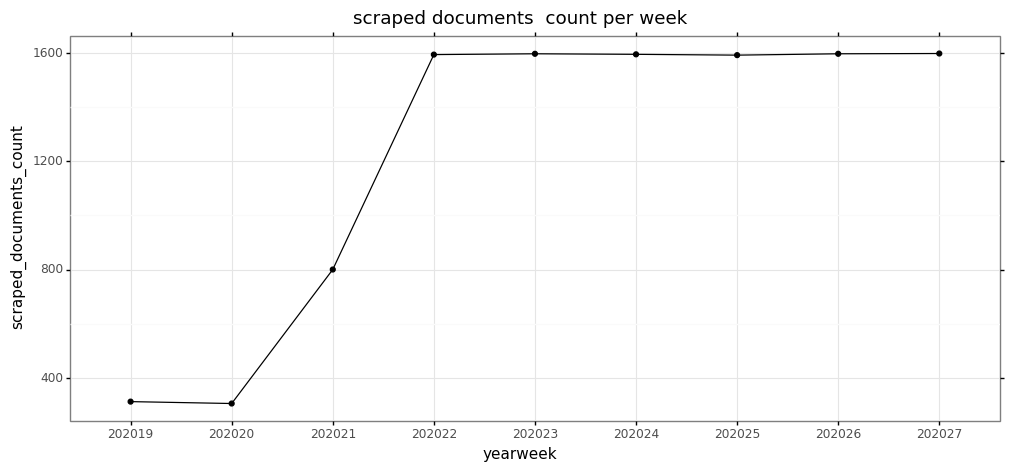

<ggplot: (-9223371874312733920)>


In [8]:
p = (ggplot(aes(x = 'yearweek', y = 'scraped_documents_count', group = 1), data = df2)
    + geom_line()
    + geom_point()
    + labs(title = 'scraped documents  count per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## number of distinct ads

In [9]:
q3 = len(adcollection.distinct('properties.link'))
print(f"Number of distinct ads: {q3}")

Number of distinct ads: 4790


## number of ads with tags

In [10]:
q4 = adcollection_d.count_documents({'tags.1':{'$exists':True}, 'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of ads with atleast 1 tag: {q4}")

Number of ads with atleast 1 tag: 2168


In [11]:
q4_0 = list(adcollection.aggregate([    
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'tags':1}
    },
    {'$match':{'tags.1':{'$exists':True}}},
    {'$group':{'_id':'$yearweek', 'documents_count':{'$sum':1}}}
    
    
]))

df4_0 = pd.json_normalize(q4_0)\
    .rename(columns = {'_id':'yearweek', 'documents_count':'ads_with_tags_count'})\
    .sort_values('yearweek')
df4_0.pivot_table(columns = 'yearweek')

yearweek             202019  202020  202021  202022  202023  202024  202025  \
ads_with_tags_count     121     109     344     689     746     744     700   

yearweek             202026  202027  
ads_with_tags_count     705     682

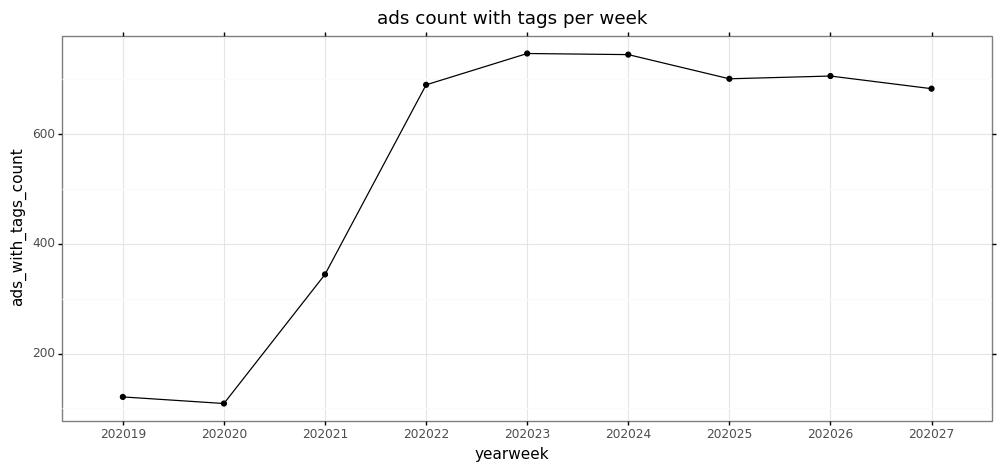

<ggplot: (-9223371874312709968)>


In [12]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_with_tags_count', group = 1), data = df4_0)
    + geom_line()
    + geom_point()
    + labs(title = 'ads count with tags per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## counts of tags

In [13]:
q4_2 = list(adcollection.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'tags':1}
    },
	{'$unwind':'$tags'},
	{'$group':{'_id':{'yearweek':'$yearweek', 'tags':'$tags'}, 'tag_count':{'$sum':1}
		}
  
  }
	
]))
	
df4_2 = pd.json_normalize(q4_2)\
    .rename(columns = {'_id.tags':'tag', '_id.yearweek':'yearweek'})\
    .sort_values('tag_count', ascending = False)

df4_3 = df4_2.pivot_table(columns = 'yearweek', index = 'tag', values = 'tag_count')
df4_3['total'] = df4_3.sum(axis = 1)
df4_3 = df4_3.sort_values(by = 'total', ascending = False)

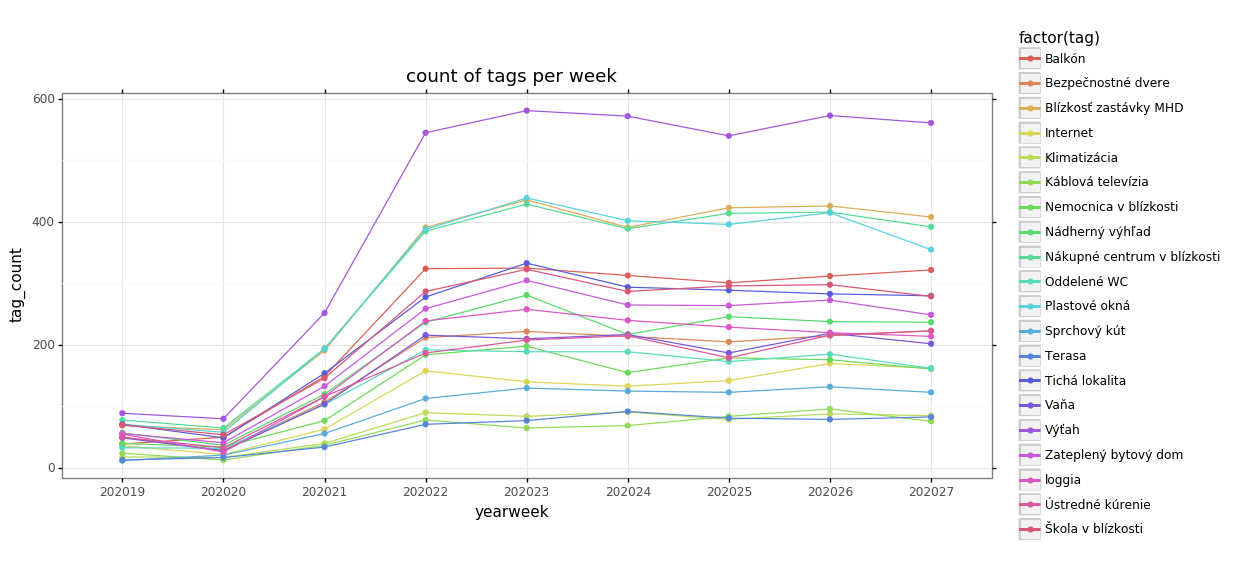

<ggplot: (-9223371874312455372)>


In [14]:
p = (ggplot(aes(x = 'yearweek', y = 'tag_count', color = 'factor(tag)', group = 'factor(tag)'), data = df4_2.loc[df4_2['tag'].isin(list(df4_3.index[:20])),:])
    + geom_line()
    + geom_point()
    + labs(title = 'count of tags per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

In [15]:
df4_3.head(20).style.format("{:.0f}")

In [16]:
q4_1 = list(adcollection_d.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$unwind':'$tags'},
	{'$group':{'_id':'$tags', 'tag_count':{'$sum':1}
		}
  
  }
	
]))
	
df4_1 = pd.json_normalize(q4_1)\
    .rename(columns = {'_id':'tag'})\
    .sort_values('tag_count', ascending = False)
df4_1.head(20)

tag  tag_count
33                        Výťah       1639
16        Blízkosť zastávky MHD       1352
26  Nákupné centrum v blízkosti       1339
82                Plastové okná       1317
35            Škola v blízkosti       1172
24               Tichá lokalita       1111
61         Zateplený bytový dom        991
0               Nádherný výhľad        902
3                        loggia        853
58                       Balkón        826
27        Nemocnica v blízkosti        711
38             Ústredné kúrenie        705
6                          Vaňa        695
74           Bezpečnostné dvere        669
22                  Oddelené WC        635
50                     Internet        535
80                 Sprchový kút        418
36            Káblová televízia        304
48                 Klimatizácia        239
62          Lokálne vykurovanie        218

## number of ads with map coordinates

In [17]:
q5 = adcollection_d.count_documents({'mapcoord.lon':{'$exists':True}, 'scraped timestamp': {'$lt': end, '$gte': start}})
print(f"Number of ads with map coordinates: {q5}")

Number of ads with map coordinates: 4224


In [18]:
q5_1 = list(adcollection.aggregate([
    {'$match': {'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                                       {'$toString':{'$week':'$scraped timestamp'}}]
                            },
                'mapcoord':1}
    },
	{'$group':{'_id':'$yearweek', 'with_mapcoord_count':{'$sum':1}
		}
  
  }
	
]))
	
df5_1 = pd.json_normalize(q5_1)\
    .rename(columns = {'_id':'yearweek'})
df5_2 = df5_1.pivot_table(columns = 'yearweek')
df5_2['total'] = df5_2.sum(axis = 1)
df5_2

yearweek             202019  202020  202021  202022  202023  202024  202025  \
with_mapcoord_count     312     305     800    1594    1597    1595    1592   

yearweek             202026  202027  total  
with_mapcoord_count    1597    1598  10990

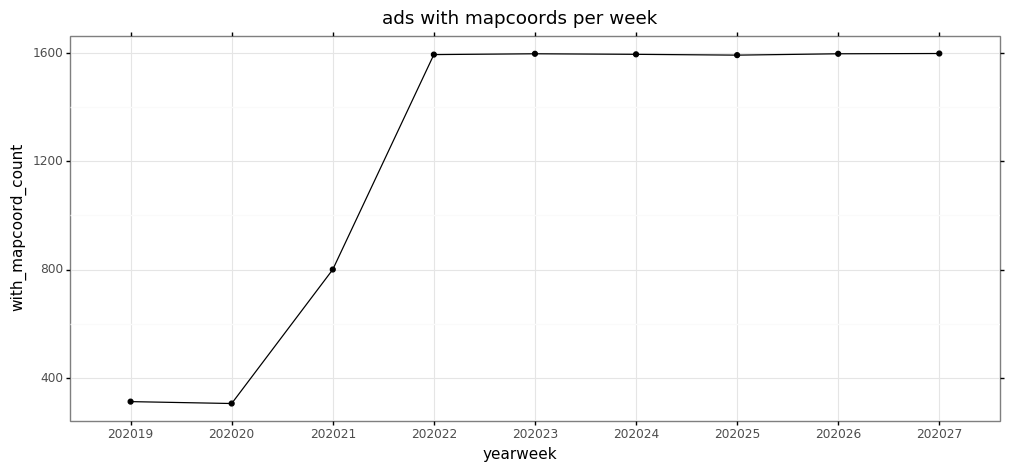

<ggplot: (-9223371874312053868)>


In [19]:
p = (ggplot(aes(x = 'yearweek', y = 'with_mapcoord_count', group = 1), data = df5_1)
    + geom_line()
    + geom_point()
    + labs(title = 'ads with mapcoords per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

## counts of keys in properties

In [20]:
q5_1 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$project':{
		'properties':{'$objectToArray':'$properties'}
		}
  
  },
	{'$unwind':'$properties'},
	{'$group':{'_id':'$properties.k',
			'ads_count':{'$sum':1}
		}
  
  }
	
]))
	
df5_1 = pd.json_normalize(q5_1)\
    .rename(columns = {'_id':'property'})\
    .sort_values('ads_count', ascending = False)
df5_1

property  ads_count
11          Aktualizácia       4790
2              Kategória       4790
3        Balkón / loggia       4790
18          Cena dohodou       4790
17               Pivnica       4790
14                  link       4790
8               Lokalita       4790
10       Úžitková plocha       4761
15       Provízia v cene       4650
21                  Cena       4650
6          Cena za meter       4609
13                 Ulica       4225
9                  Výťah       3914
0   Identifikačné číslo:       3911
16        Pocet poschodi       3860
4              Poschodie       3860
1                   Stav       3431
12              Materiál       2575
7    Stav nehnuteľnosti:       1418
19      Zastavaná plocha        103
5             Pozemok m2         80
20                empty1         24

## counts of distinct values in properties

In [21]:
q5_2 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$project':{
		'properties':{'$objectToArray':'$properties'}
		}
  
  },
	{'$unwind':'$properties'},
	{'$group':{'_id':'$properties.k',
			'unique_values':{'$addToSet': "$properties.v"}
		}
    },
     {'$project':{'_id':1,
                 'unique_values_count':{'$size':'$unique_values'}}
     
     }
  

	
]))
	
df5_2 = pd.json_normalize(q5_2)\
    .rename(columns = {'_id':'property'})\
    .sort_values('unique_values_count', ascending = False)
df5_2

property  unique_values_count
3                   link                 4790
12  Identifikačné číslo:                 3521
0           Aktualizácia                 2057
16         Cena za meter                 1718
9                   Cena                 1071
4                  Ulica                  789
2        Úžitková plocha                  218
20              Lokalita                   67
10      Zastavaná plocha                   63
19            Pozemok m2                   56
8         Pocet poschodi                   33
18             Poschodie                   27
11                empty1                   12
15             Kategória                   10
1               Materiál                    5
14                  Stav                    4
7        Provízia v cene                    3
13       Balkón / loggia                    2
6           Cena dohodou                    2
5                Pivnica                    2
21                 Výťah                    2
17   Stav nehnuteľnosti:                    1

## number of ads per flat category

In [22]:
q6 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                               {'$toString':{'$week':'$scraped timestamp'}}]
                    },
        'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'flat_category':'$properties.Kategória'}, 'ads_count':{'$sum':1}}}]))

df6 = pd.json_normalize(q6)\
    .rename(columns = {'_id.yearweek':'yearweek', '_id.flat_category':'flat_category'})\
    .sort_values('ads_count', ascending = False)
df7 = df6.pivot_table(columns = 'yearweek', index = 'flat_category', values = 'ads_count')
df7['total'] = df7.sum(axis = 1)

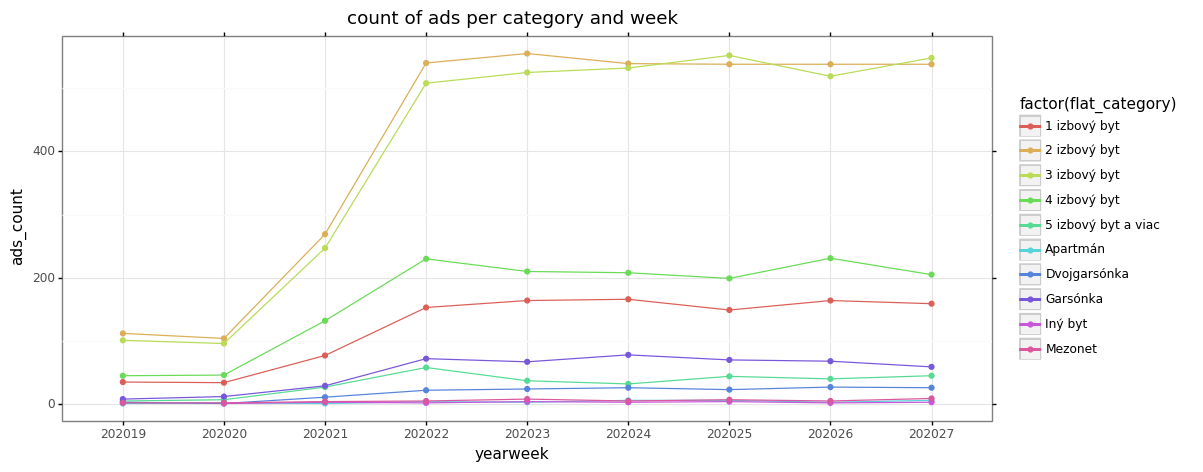

<ggplot: (-9223371874311749688)>


In [23]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(flat_category)', group = 'factor(flat_category)'), 
            data = df6)
    + geom_line()
    + geom_point()
    + labs(title = 'count of ads per category and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))
print(p)

In [24]:
df7.style.format("{:.0f}")

In [25]:
q6_1 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':'$properties.Kategória', 'ads_count':{'$sum':1}}}]))

df6_1 = pd.json_normalize(q6_1)\
    .rename(columns = {'_id':'flat_category'})\
    .sort_values('ads_count', ascending = False)
df6_1

flat_category  ads_count
1         2 izbový byt       1645
9         3 izbový byt       1596
5         4 izbový byt        617
7         1 izbový byt        490
0             Garsónka        227
8  5 izbový byt a viac        105
6         Dvojgarsónka         74
2              Mezonet         18
4             Apartmán         12
3              Iný byt          6

## number of ads per state and category

In [26]:
q8 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                           {'$toString':{'$week':'$scraped timestamp'}}]
                },
    'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'kategoria':'$properties.Kategória', 'stav':'$properties.Stav'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.stav':'state', '_id.yearweek':'yearweek'})\
    .sort_values(['state', 'ads_count'], ascending = False)
df8 = df8[['state', 'category', 'yearweek','ads_count']]
df9 = df8.pivot_table(index=['category','state'], columns='yearweek', values='ads_count')
df9['total'] = df9.sum(axis = 1)

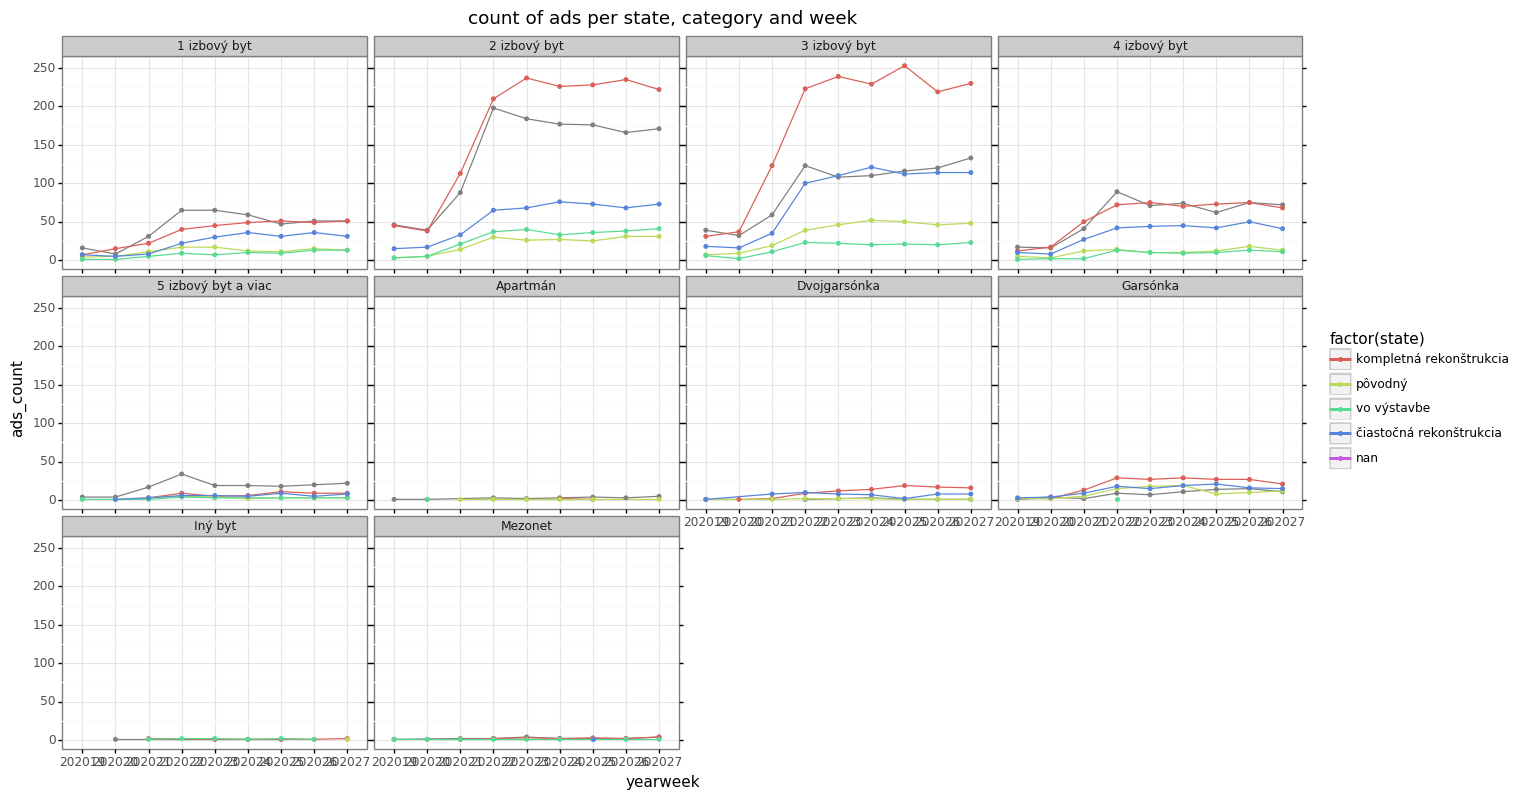

<ggplot: (-9223371874312477828)>


In [27]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(state)', group = 'factor(state)'), 
            data = df8)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'count of ads per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [28]:
df9.style.format("{:.0f}", na_rep = '-')

In [29]:
q8 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':{'kategoria':'$properties.Kategória', 'stav':'$properties.Stav'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.stav':'state'})\
    .sort_values(['state', 'ads_count'], ascending = False)
df8 = df8[['state', 'category', 'ads_count']]
df8 = df8.pivot(index='state', columns='category', values='ads_count')
df8['state_count'] = df8.sum(axis = 1)
df8 = df8.sort_values('state_count', ascending = False)
df8.style.format("{:.0f}", na_rep = '-')

## number of ads per location and category

### counts

In [30]:
q10 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$group':{'_id':{'kategoria':'$properties.Kategória', 'lokalita':'$properties.Lokalita'}, 'ads_count':{'$sum':1}}}]))

df10 = pd.json_normalize(q10)\
    .rename(columns = {'_id.kategoria':'category', '_id.lokalita':'location'})
df10 = df10.pivot(index='location', columns='category', values='ads_count')
df10['location_count'] = df10.sum(axis = 1)
df10 = df10.sort_values('location_count', ascending = False)
df10.head(30).style.format("{:.0f}", na_rep = '-')

### percent

In [31]:
df11 = df10.iloc[:,[i for i in range(0, 10)]].apply(lambda x: x/df10['location_count'])
df11.head(30).style.format("{:.2%}", na_rep = '-')

### mean percent of category in top few locations

In [32]:
df11.loc[locs,:].mean().to_frame().style.format("{:.2%}")


## counts per yearweek

In [33]:
q8 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                           {'$toString':{'$week':'$scraped timestamp'}}]
                },
    'properties':1}
    },
    {'$group':{'_id':{'yearweek':'$yearweek', 'kategoria':'$properties.Kategória', 'location':'$properties.Lokalita'}, 'ads_count':{'$sum':1}}}]))

df8 = pd.json_normalize(q8)\
    .rename(columns = {'_id.kategoria':'category', '_id.location':'location', '_id.yearweek':'yearweek'})
df8 = df8[['location', 'category', 'yearweek','ads_count']]
df8 = df8.loc[df8['location'].isin(locs),:]
df9 = df8.pivot_table(index=['category','location'], columns='yearweek', values='ads_count')
df9['total'] = df9.sum(axis = 1)

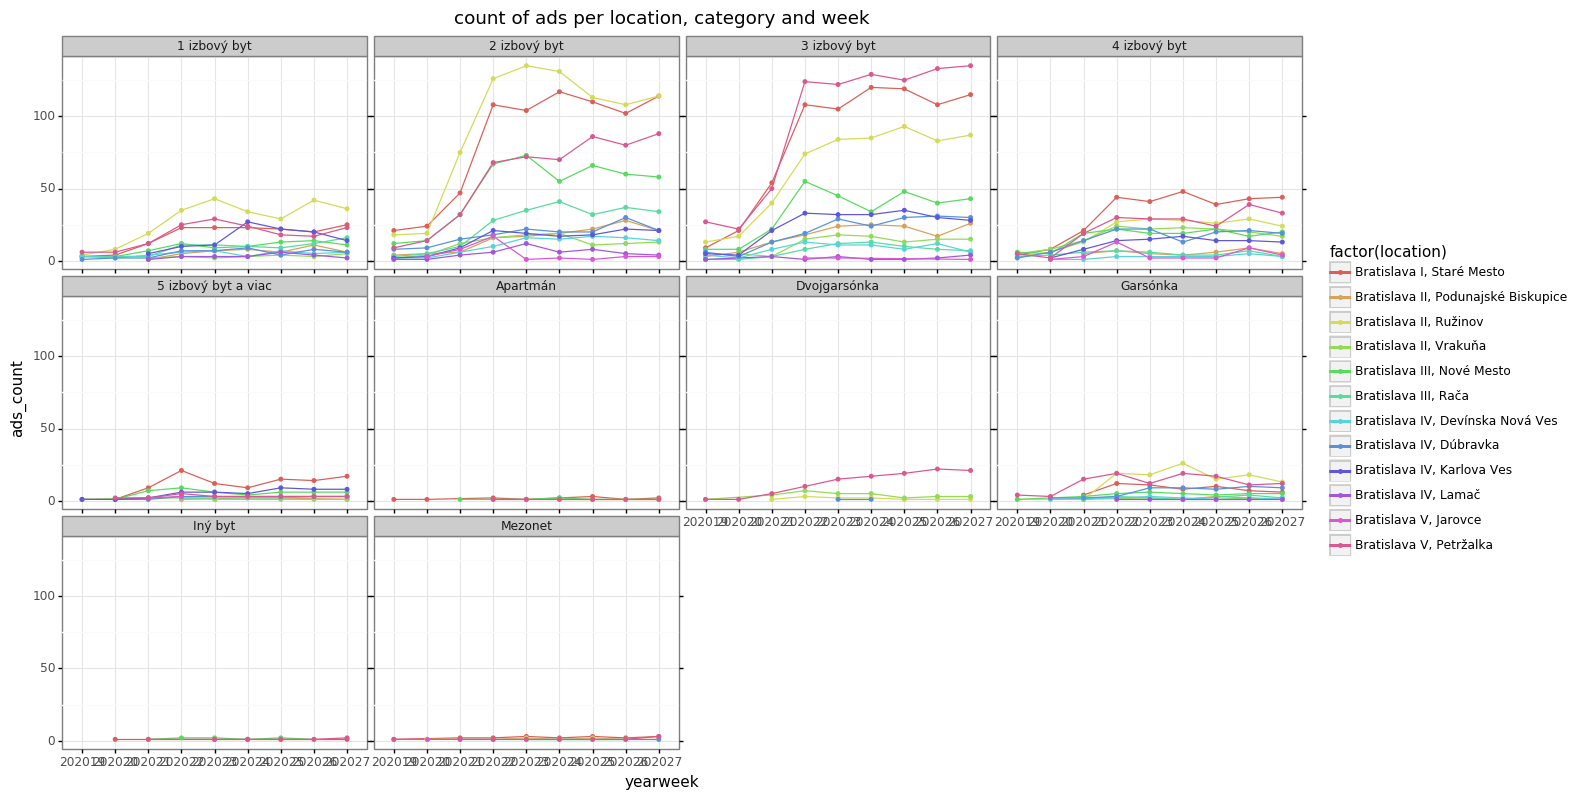

<ggplot: (-9223371874310149916)>


In [34]:
p = (ggplot(aes(x = 'yearweek', y = 'ads_count', color = 'factor(location)', group = 'factor(location)'), 
            data = df8)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'count of ads per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [35]:
df9.style.format("{:.0f}", na_rep = '-')

# AVG PRICE

In [36]:
q12 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':'global',
			'price_avg':{'$avg':'$properties.Cena'}
		}
  
  }
	
]))[0]['price_avg']

print(f"Average price of whole set: {q12}")

Average price of whole set: 193400.21978494624


In [37]:
q12 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                       {'$toString':{'$week':'$scraped timestamp'}}]
            },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek'},
			'price_avg':{'$avg':'$properties.Cena'}
		}
  
  }
	
]))
	
df12 = pd.json_normalize(q12)\
    .rename(columns = {'_id.yearweek':'yearweek'})
df13 = df12.pivot_table(columns = 'yearweek')
df13.style.format("{:,.0f}")


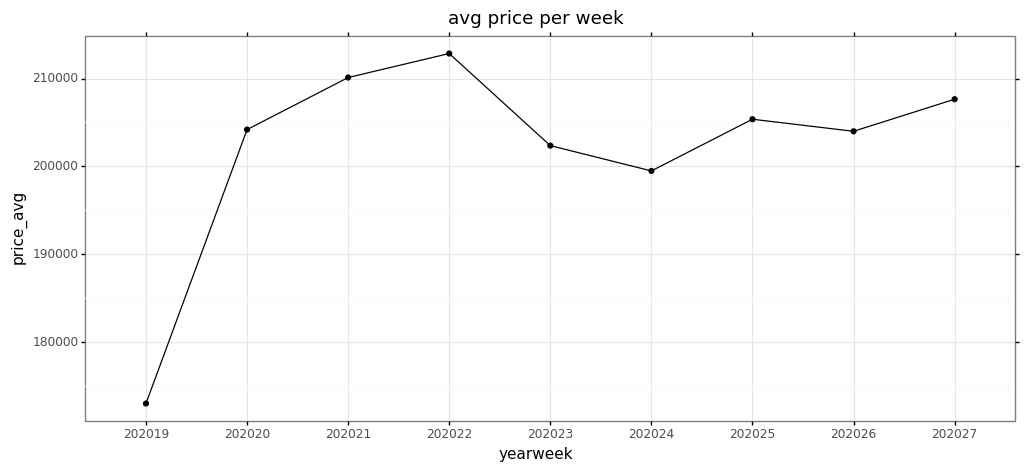

<ggplot: (-9223371874309869516)>


In [38]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', group = 1), 
            data = df12)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per category

In [39]:
q13 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
                   {'$toString':{'$week':'$scraped timestamp'}}]
        },
    'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df13 = df13[['category', 'yearweek', 'price_avg']]
df14 = df13.pivot_table(columns = 'yearweek', index = 'category', values = 'price_avg')

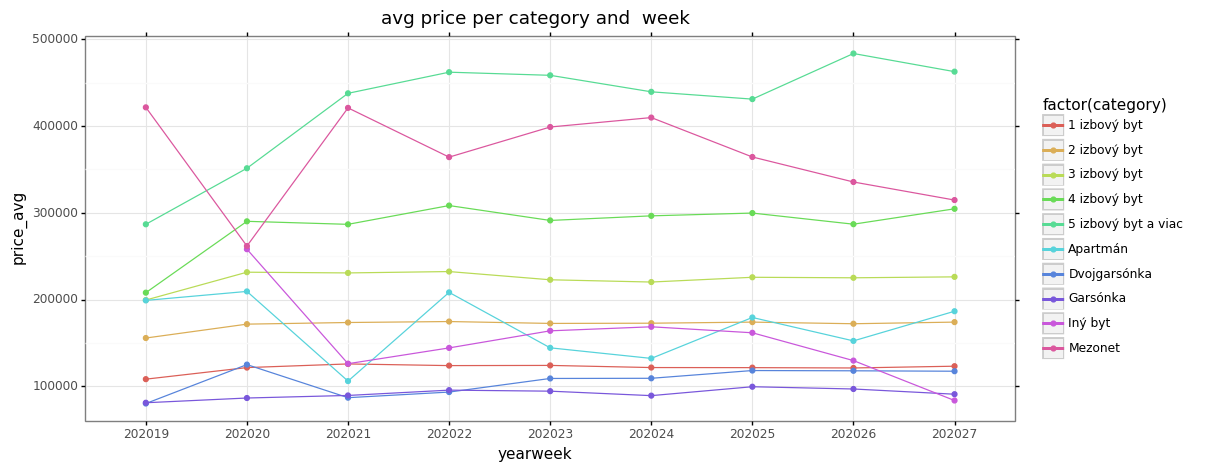

<ggplot: (-9223371874310642952)>


In [40]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(category)', group = 'factor(category)'), 
            data = df13)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per category and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [41]:
df14.style.format("{:,.0f}")

In [42]:
q13 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
            'ads_count':{'$sum':1}}  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df13 = df13[['category', 'price_avg', 'ads_count']]
df13.style.format({'price_avg':"{:,.0f}"})

## avg price per location

In [43]:
q14 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
               {'$toString':{'$week':'$scraped timestamp'}}]
    },
    'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek','location':'$properties.Lokalita'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location', '_id.yearweek':'yearweek'})
df14 = df14.loc[df14['location'].isin(locs), ['location', 'yearweek', 'price_avg']]
df15 = df14.pivot_table(columns = 'yearweek', index = 'location', values = 'price_avg')

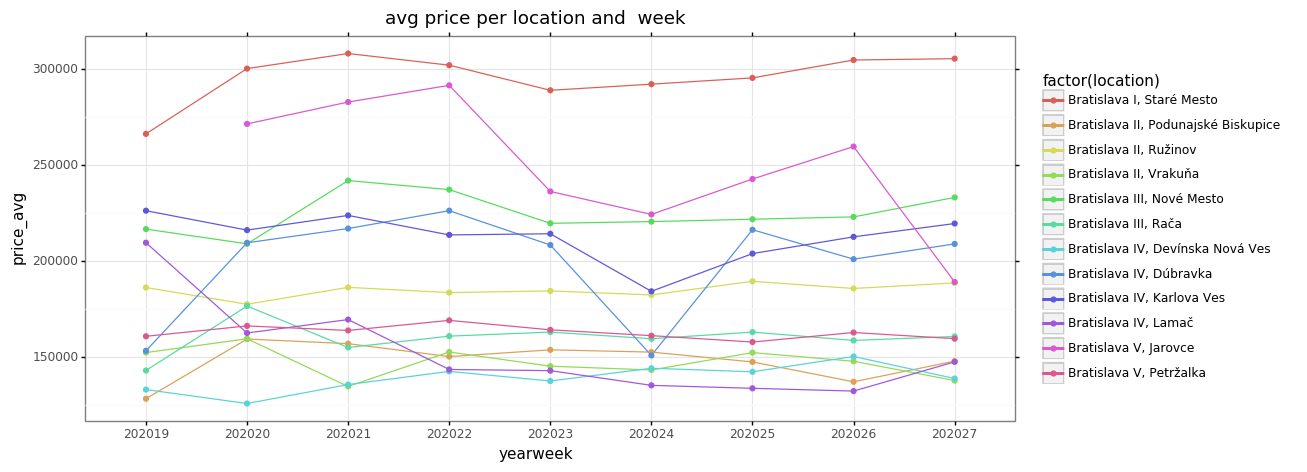

<ggplot: (-9223371874310635916)>


In [44]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df14)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per location and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [45]:
df15.style.format("{:,.0f}")

In [46]:
q14 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location'})\
    .sort_values('price_avg', ascending = False)
df14 = df14[['location', 'price_avg', 'ads_count']]
df15 = df14.loc[df14['location'].isin(locs),:]
df15.style.format({'price_avg':"{:,.0f}"})

## avg price per location and category

In [47]:
q16 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
           {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}  
  }
	
]))
	
df16 = pd.json_normalize(q16)\
    .rename(columns = {'_id.location':'location', '_id.category':'category', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df16 = df16.loc[df16['location'].isin(locs), ['location', 'yearweek', 'category', 'price_avg']]
df17 = df16.pivot_table(columns = 'yearweek', index = ['category', 'location'], values = 'price_avg')

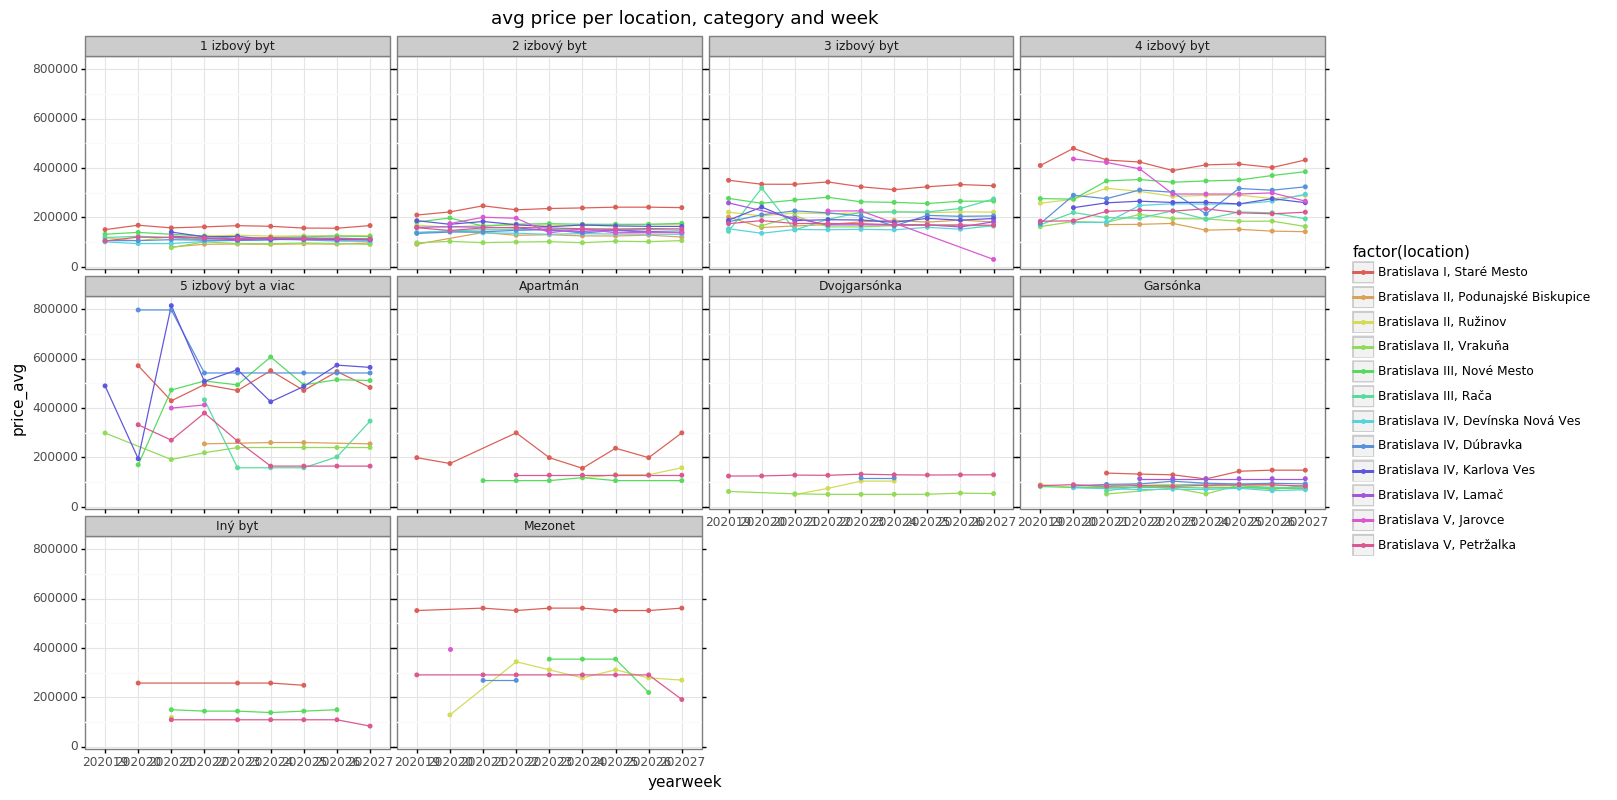

<ggplot: (-9223371874312389996)>


In [48]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [49]:
df17.style.format("{:,.0f}", na_rep = '-')

In [50]:
q17 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}  
  }
	
]))
	
df17 = pd.json_normalize(q17)\
    .rename(columns = {'_id.location':'location', '_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df17 = df17[['location', 'category', 'price_avg', 'ads_count']]
df17.loc[df17['location'].isin(locs),:]
df18 = df17.loc[df17['location'].isin(locs),:].pivot(index='location', columns='category', values='price_avg')
df18.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

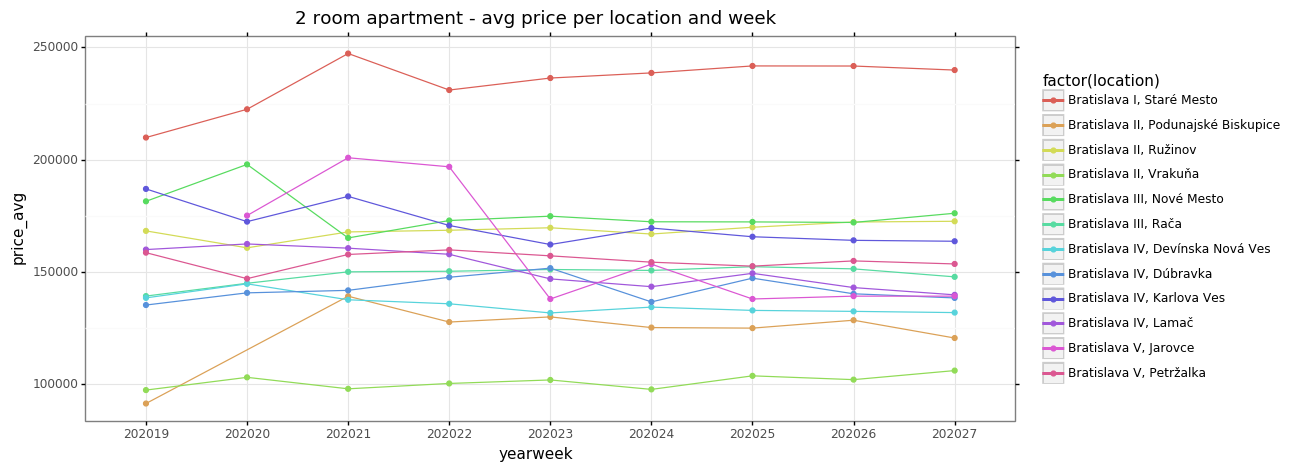

<ggplot: (-9223371874310288236)>


In [51]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

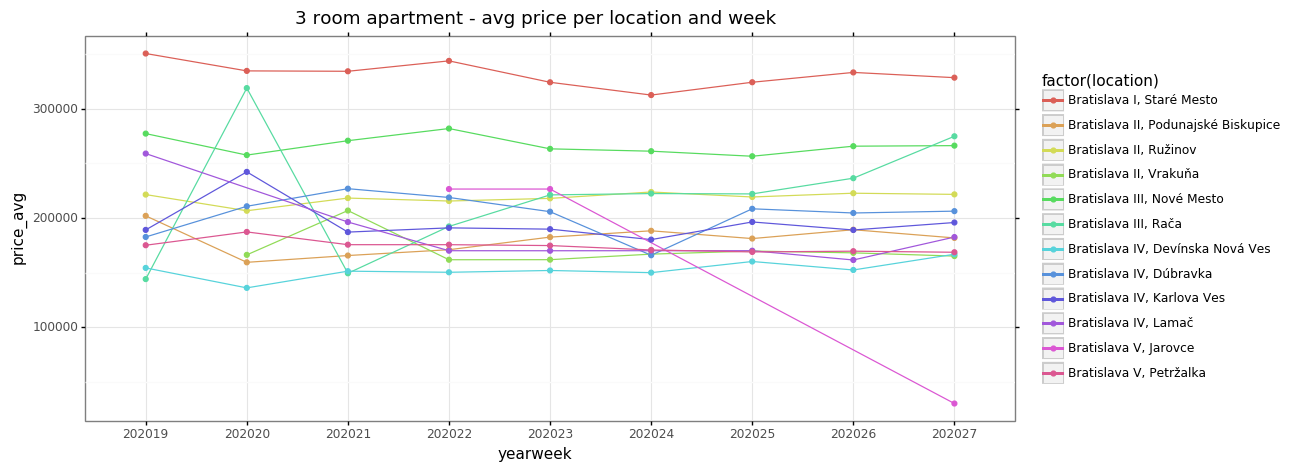

<ggplot: (-9223371874310275196)>


In [52]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per state

In [53]:
q18 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'}}
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state', '_id.yearweek':'yearweek'})\
    .sort_values('price_avg', ascending = False)
df18 = df18[['state', 'yearweek', 'price_avg']]
df19 = df18.pivot_table(columns = 'yearweek', index = 'state', values = 'price_avg')

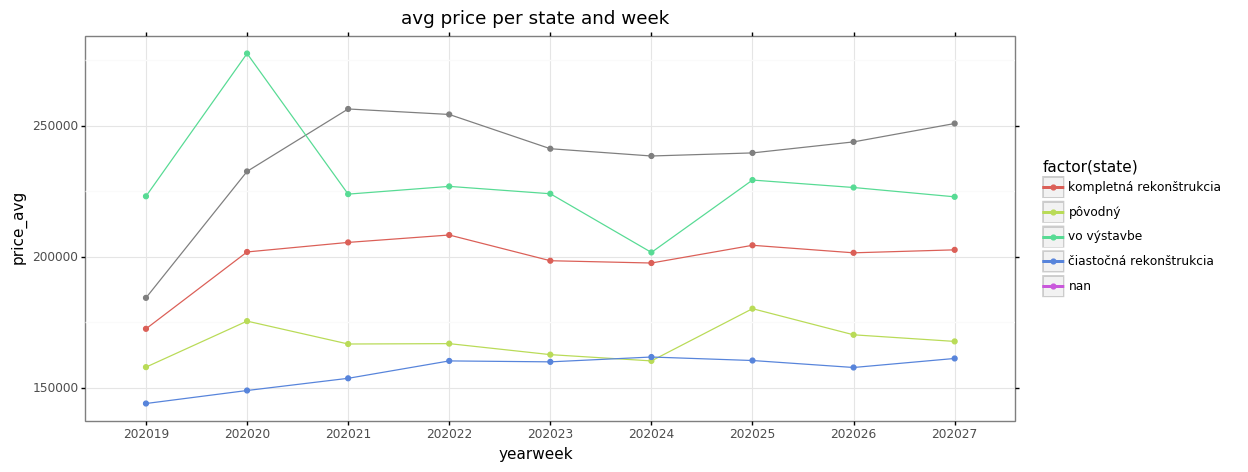

<ggplot: (-9223371874310306760)>


In [54]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df18)
    + geom_line()
    + geom_point()
    + labs(title = 'avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [55]:
df19.style.format("{:,.0f}")

In [56]:
q18 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state'})\
    .sort_values('price_avg', ascending = False)
df18 = df18[['state', 'price_avg', 'ads_count']]
df18.style.format({'price_avg':"{:,.0f}"})

## avg price per state and category

In [57]:
q19 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df19 = df19[['state', 'category', 'yearweek', 'price_avg']]
df20 = df19.pivot_table(index = ['state', 'category'], columns = 'yearweek', values = 'price_avg')

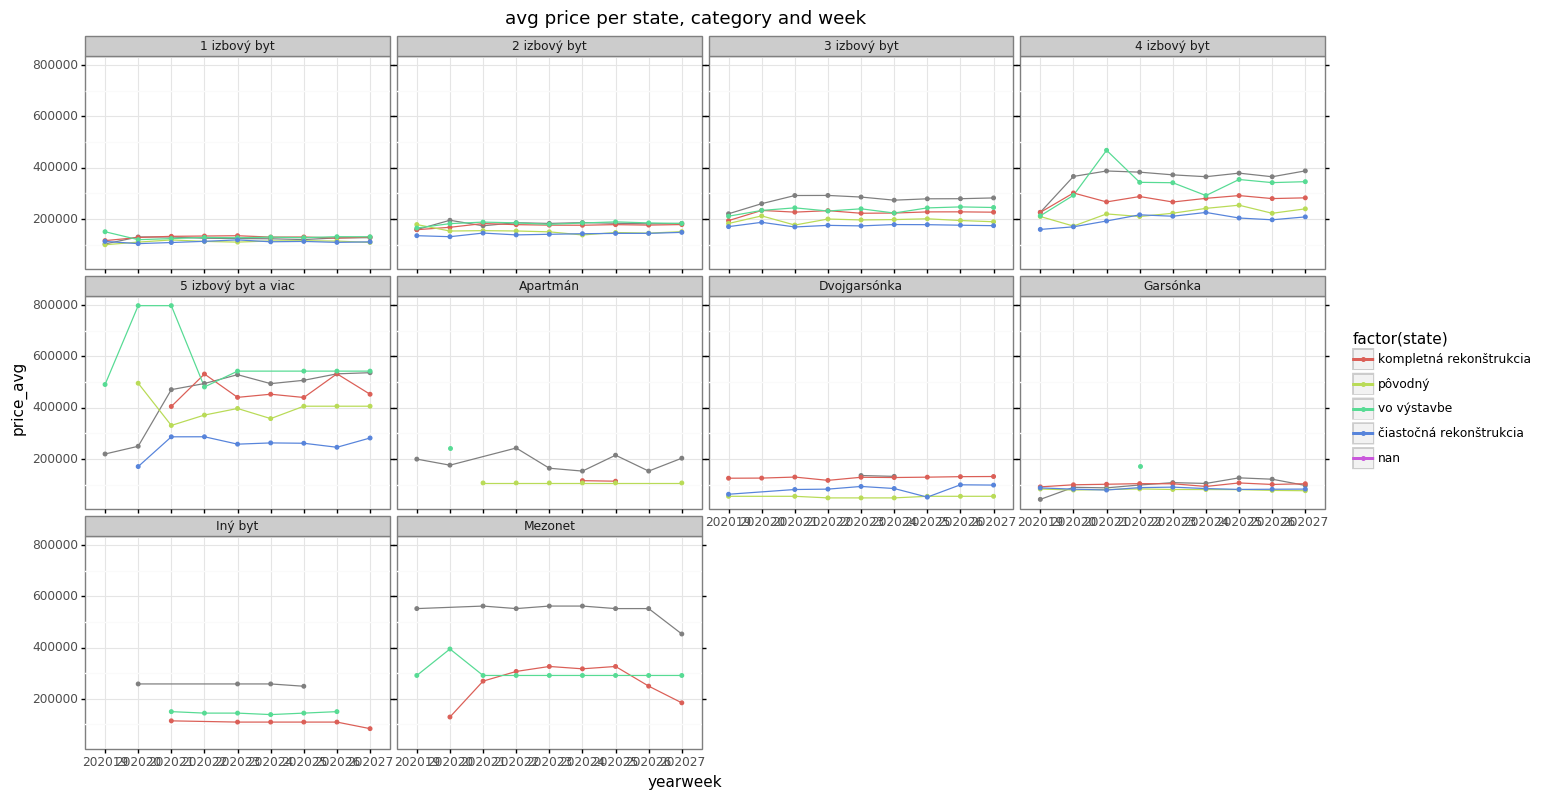

<ggplot: (-9223371874311769772)>


In [58]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [59]:
df20.style.format("{:,.0f}", na_rep = '-')

In [60]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.state':'state', '_id.category':'category'})\
    .sort_values(['state', 'price_avg'], ascending = False)
df20 = df20[['state', 'category', 'price_avg', 'ads_count']]
df20 = df20.pivot(index = 'state', columns = 'category', values = 'price_avg')
df20.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

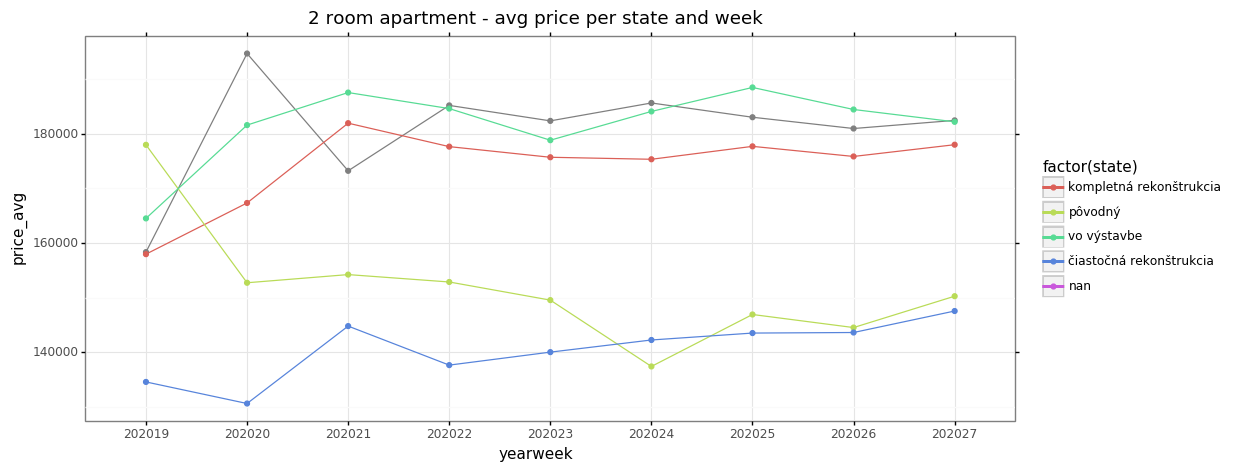

<ggplot: (-9223371874309928428)>


In [61]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19.loc[df19['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

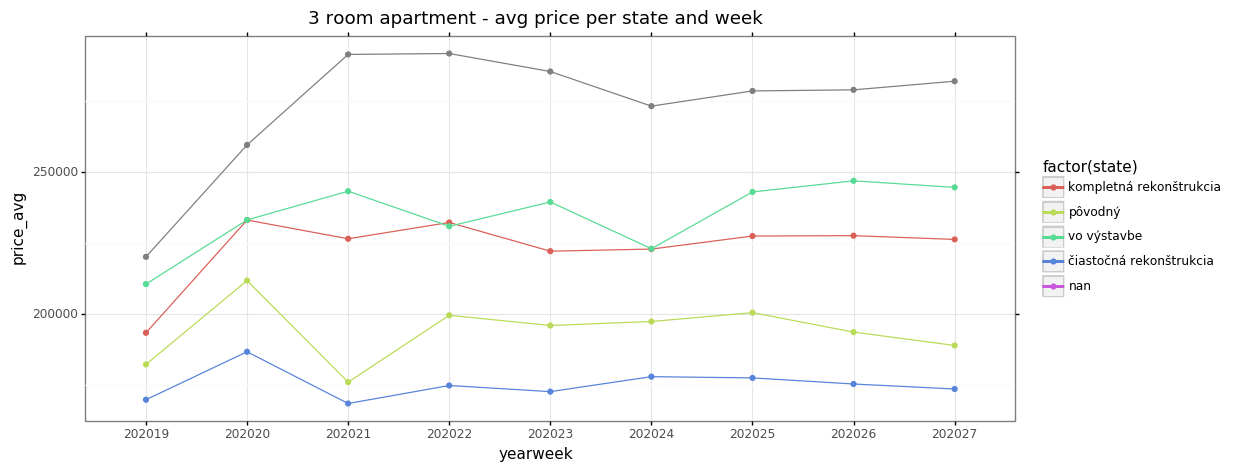

<ggplot: (-9223371874311782052)>


In [62]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19.loc[df19['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg price per state and location

In [63]:
q20 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
        {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.yearweek':'yearweek'})
df20 = df20[['location', 'yearweek', 'state', 'price_avg']]
df21 = df20.loc[df20['location'].isin(locs),:].pivot_table(index = ['state', 'location'], columns = 'yearweek', values = 'price_avg')

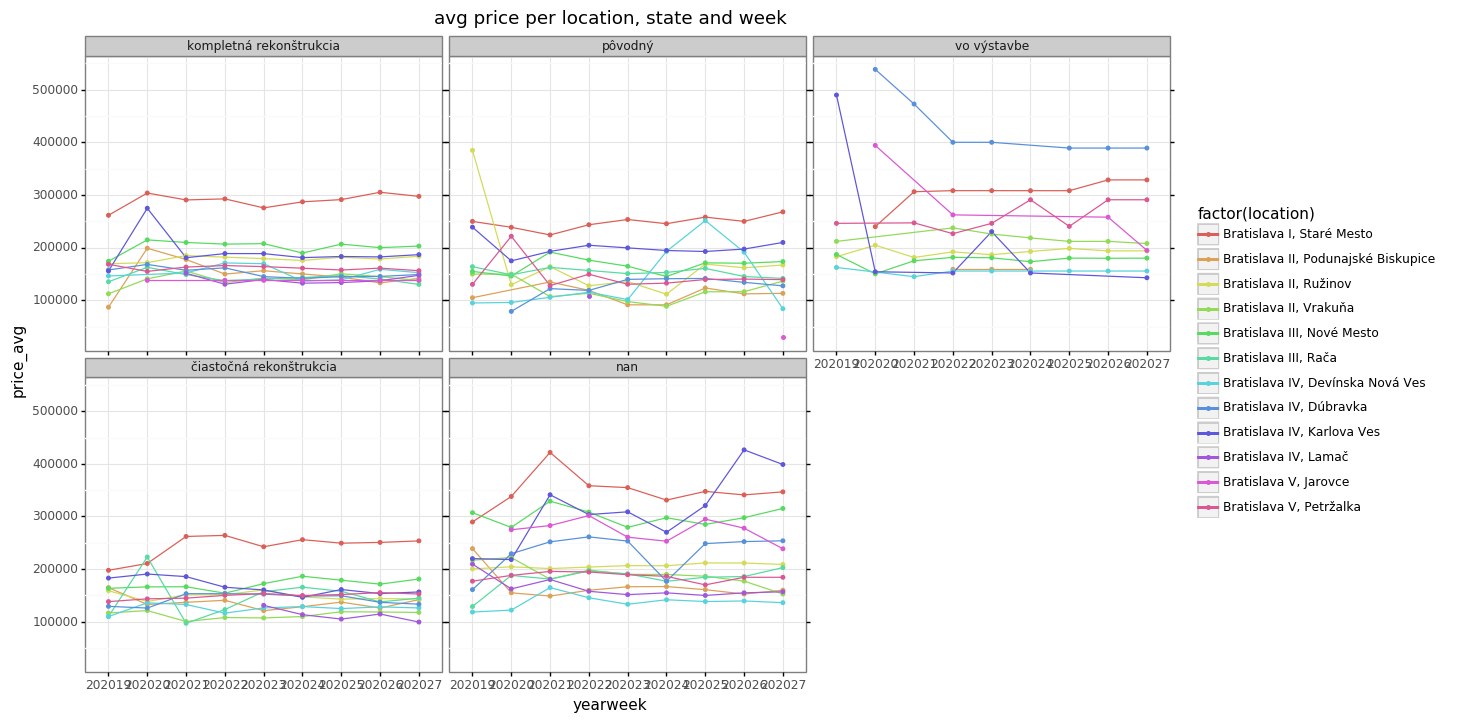

<ggplot: (-9223371874309933852)>


In [64]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df20.loc[df20['location'].isin(locs),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [65]:
df21.style.format("{:,.0f}", na_rep = '-')

In [66]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state'})\
    .sort_values('price_avg', ascending = False)
df20 = df20[['location', 'state', 'price_avg', 'ads_count']]
df20 = df20.loc[df20['location'].isin(locs),:].pivot(index = 'location', columns = 'state', values = 'price_avg')
df20.style.format("{:,.0f}", na_rep = '-')

## avg price per state, location and category

In [67]:
q21 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'}}
		
  
  }
	
]))
	
df21 = pd.json_normalize(q21)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df22 = df21.loc[df21['location'].isin(locs),:].pivot_table(index = ['category', 'state', 'location'], columns = 'yearweek', values = 'price_avg')
df22.style.format("{:,.0f}", na_rep = '-')

In [68]:
q22 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_avg':{'$avg':'$properties.Cena'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df22 = pd.json_normalize(q22)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category'})\
    .sort_values('price_avg', ascending = False)
df22 = df22.loc[df22['location'].isin(locs),:].pivot_table(index = ['location', 'category'], columns = 'state', values = ['price_avg', 'ads_count'])
df22.columns = df22.columns.swaplevel(0, 1)
df22.sort_index(axis=1, level=0, inplace=True)
df22.style.format("{:,.0f}", na_rep = '-')

### 2 room apartment

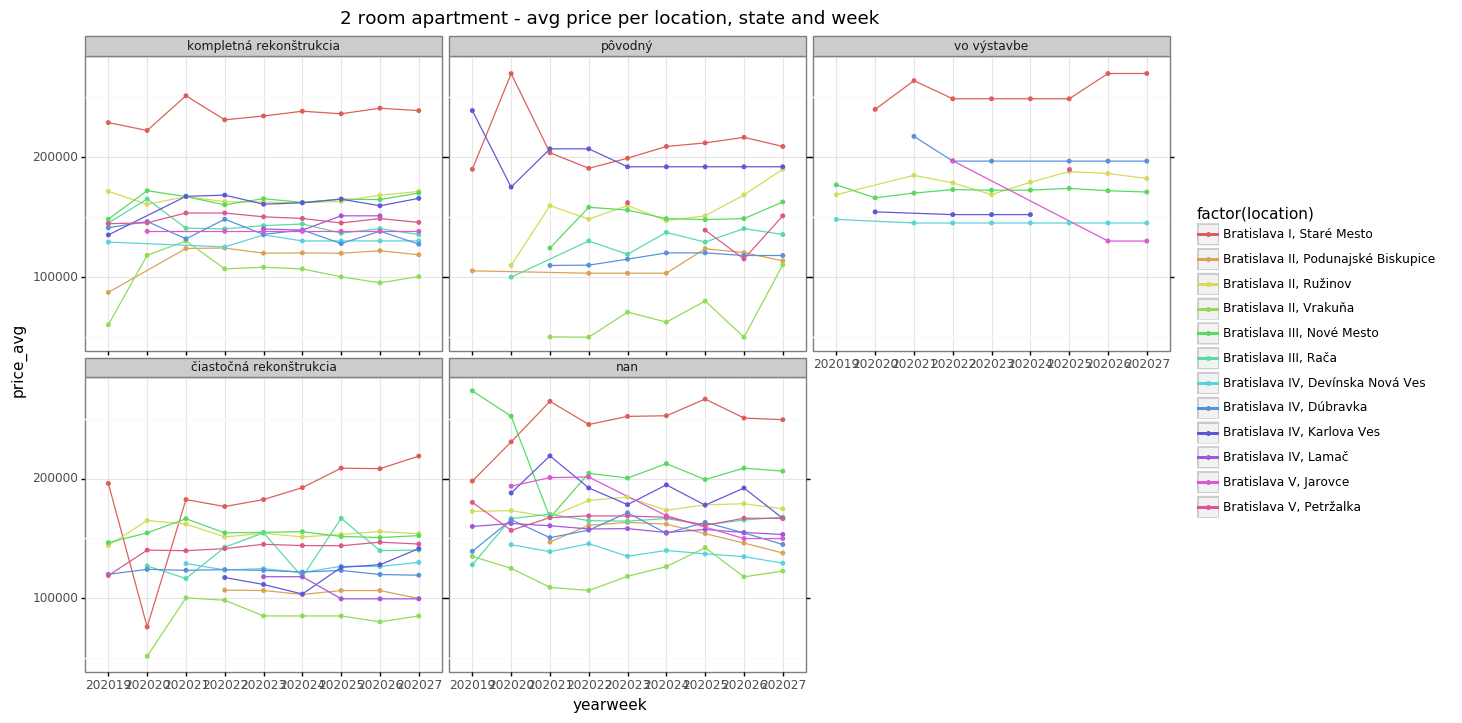

<ggplot: (-9223371874309990312)>


In [69]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '2 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment - avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

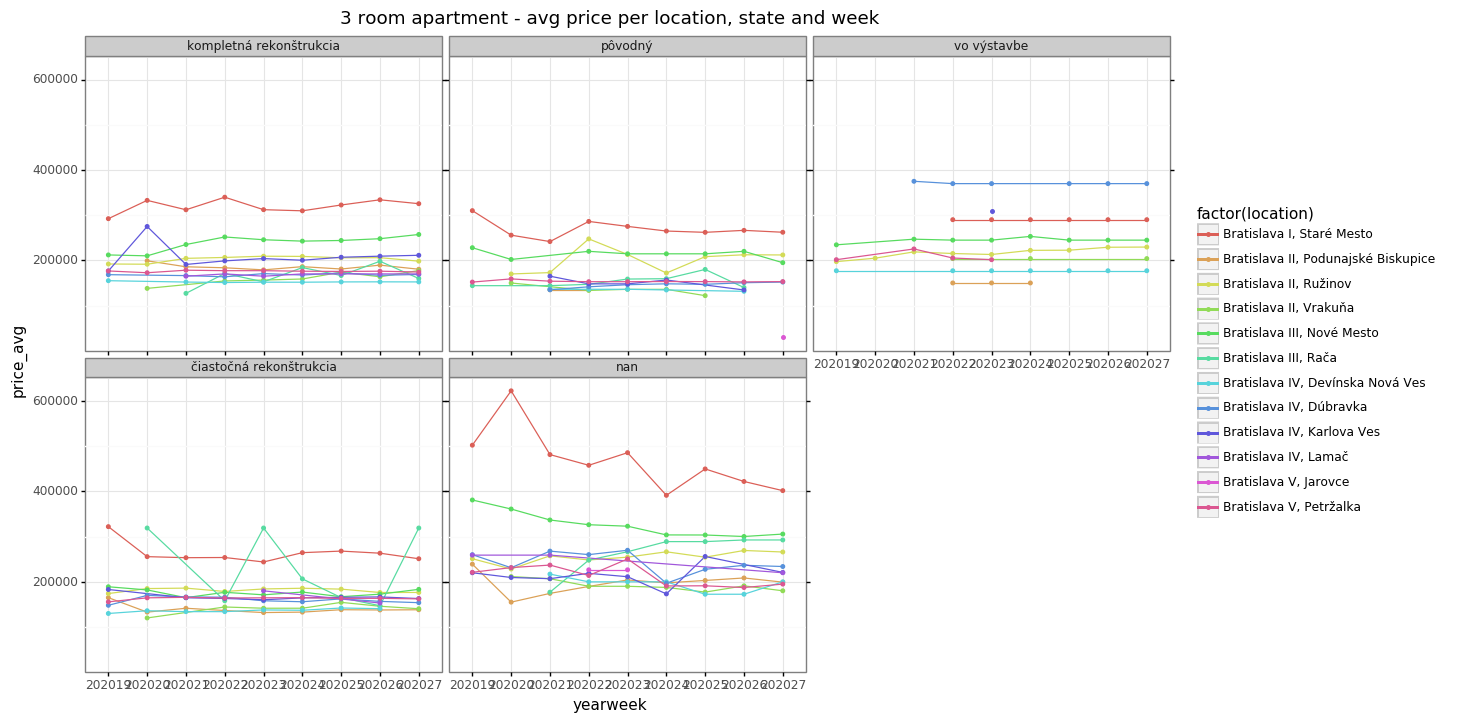

<ggplot: (-9223371874312474088)>


In [70]:
p = (ggplot(aes(x = 'yearweek', y = 'price_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '3 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment - avg price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# AVG M2 PRICE

In [71]:
q12 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':'global',
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}
		}
  
  }
	
]))[0]['price_m2_avg']
	
print(f"Average price of whole set: {q12}")


Average price of whole set: 2904.7372532002605


In [72]:
q12 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':'$yearweek',
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}
		}
  
  }
	
]))
	
df12 = pd.json_normalize(q12)\
    .rename(columns = {'_id':'yearweek'})
df13 = df12.pivot_table(columns = 'yearweek')
df13.style.format("{:.0f}")

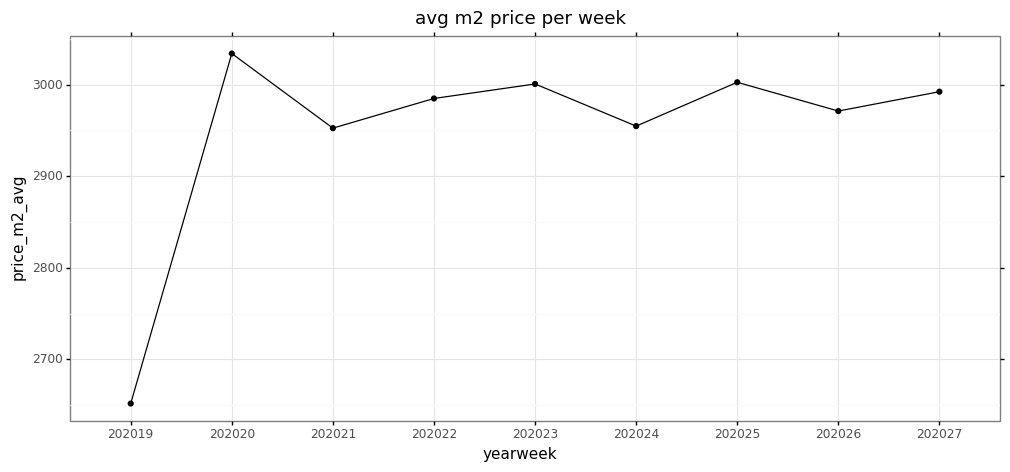

<ggplot: (-9223371874311851720)>


In [73]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', group = 1), 
            data = df12)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg m2 price per category

In [74]:
q13 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category', '_id.yearweek':'yearweek'})
df13 = df13[['category', 'yearweek', 'price_m2_avg']]
df14 = df13.pivot_table(columns = 'yearweek', index = 'category', values = 'price_m2_avg')

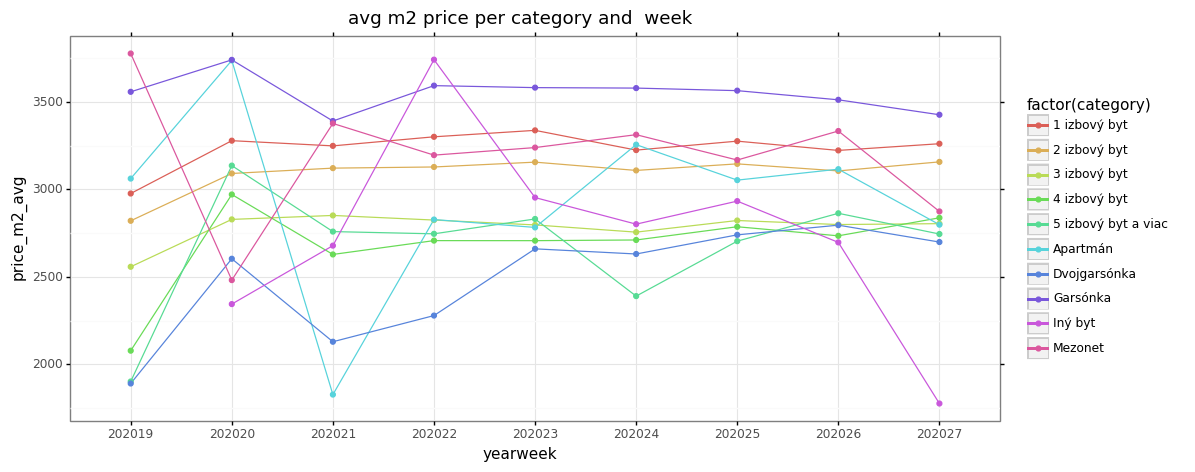

<ggplot: (-9223371874310603104)>


In [75]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(category)', group = 'factor(category)'), 
            data = df13)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per category and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [76]:
df14.style.format("{:.0f}")

In [77]:
q13 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df13 = pd.json_normalize(q13)\
    .rename(columns = {'_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df13 = df13[['category', 'price_m2_avg']]
df13.style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per location

In [78]:
q14 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location', '_id.yearweek':'yearweek'})
df14 = df14.loc[df14['location'].isin(locs), ['location', 'yearweek','price_m2_avg']]
df15 = df14.pivot_table(columns = 'yearweek', index = 'location', values = 'price_m2_avg')

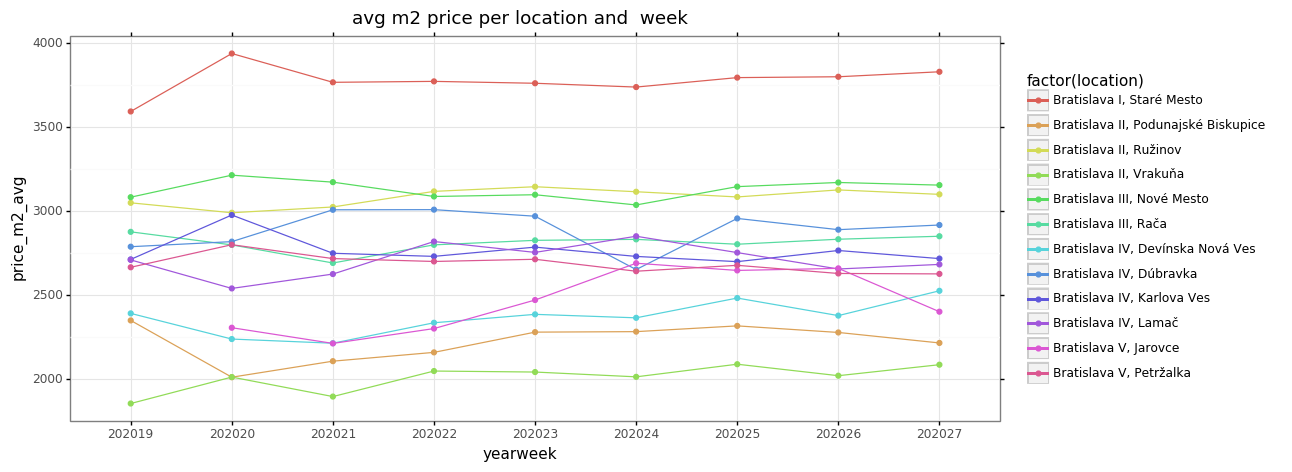

<ggplot: (-9223371874308389728)>


In [79]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df14)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per location and  week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [80]:
df15.style.format("{:.0f}")

In [81]:
q14 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df14 = pd.json_normalize(q14)\
    .rename(columns = {'_id.location':'location'})\
    .sort_values('price_m2_avg', ascending = False)
df14 = df14[['location', 'price_m2_avg', 'ads_count']]
df14.loc[df14['location'].isin(locs),:].style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per location and category

In [82]:
q16 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}	
  
  }
	
]))
	
df16 = pd.json_normalize(q16)\
    .rename(columns = {'_id.location':'location', '_id.category':'category', '_id.yearweek':'yearweek'})
df16 = df16.loc[df16['location'].isin(locs), ['location', 'category', 'yearweek', 'price_m2_avg']]
df17 = df16.pivot_table(columns = 'yearweek', index = ['category', 'location'], values = 'price_m2_avg')

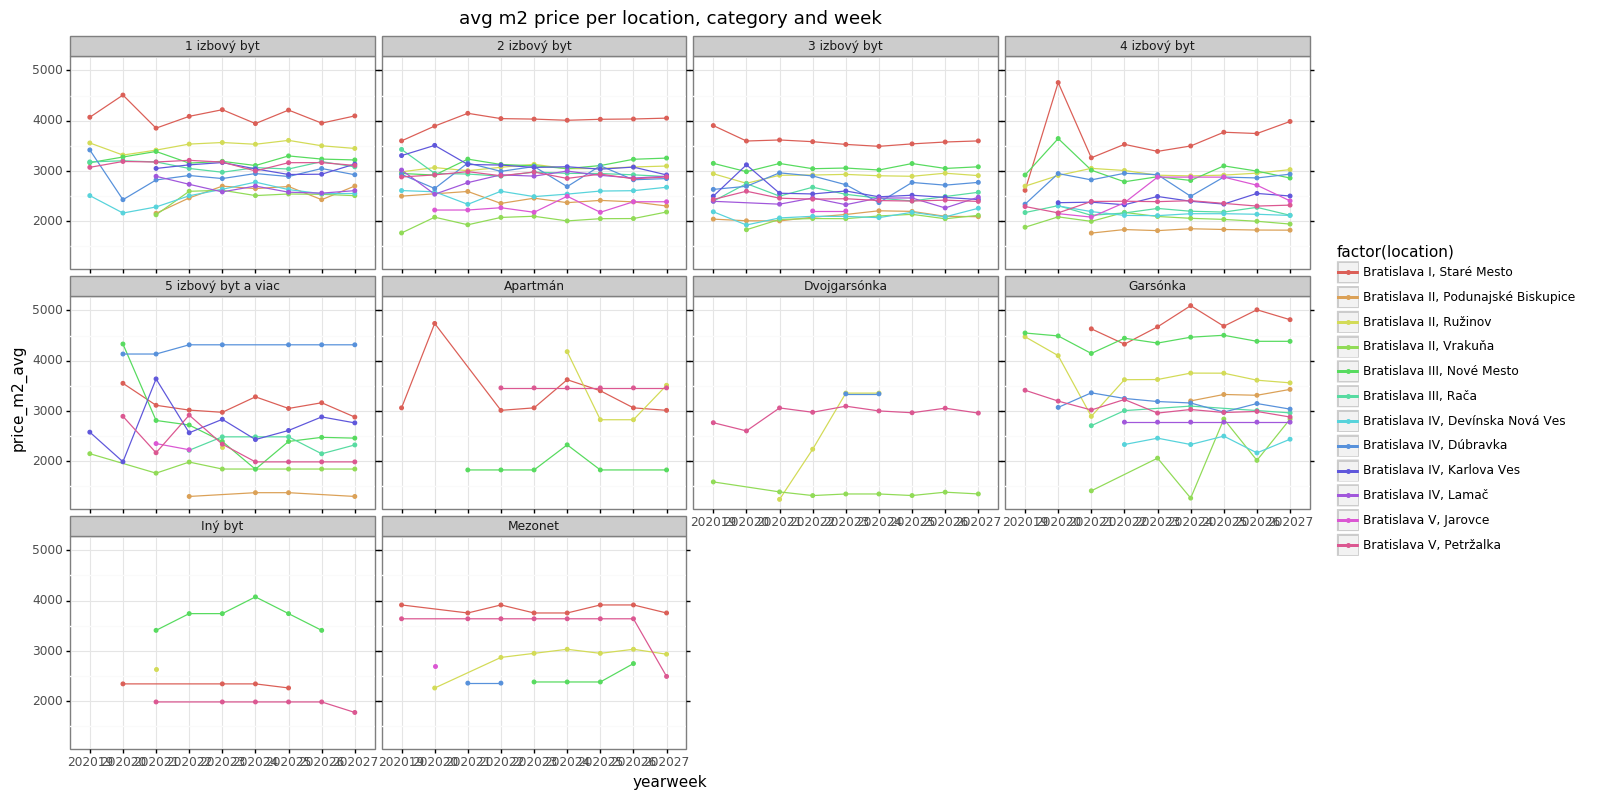

<ggplot: (-9223371874312473968)>


In [83]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per location, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [84]:
df17.style.format("{:.0f}", na_rep = '-')

In [85]:
q17 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df17 = pd.json_normalize(q17)\
    .rename(columns = {'_id.location':'location', '_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df17 = df17[['location', 'category', 'price_m2_avg', 'ads_count']]
df18 = df17.loc[df17['location'].isin(locs),:].pivot(index='location', columns='category', values='price_m2_avg')
df18.style.format("{:.0f}", na_rep = '-')

### 2 room apartment

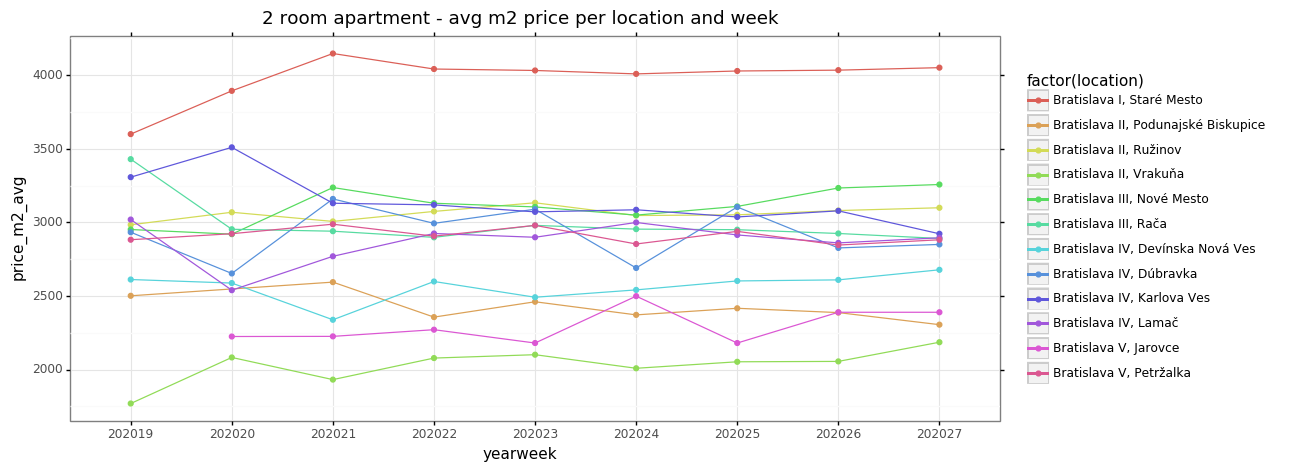

<ggplot: (-9223371874310304060)>


In [86]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '2 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '2 room apartment - avg m2 price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

### 3 room apartment

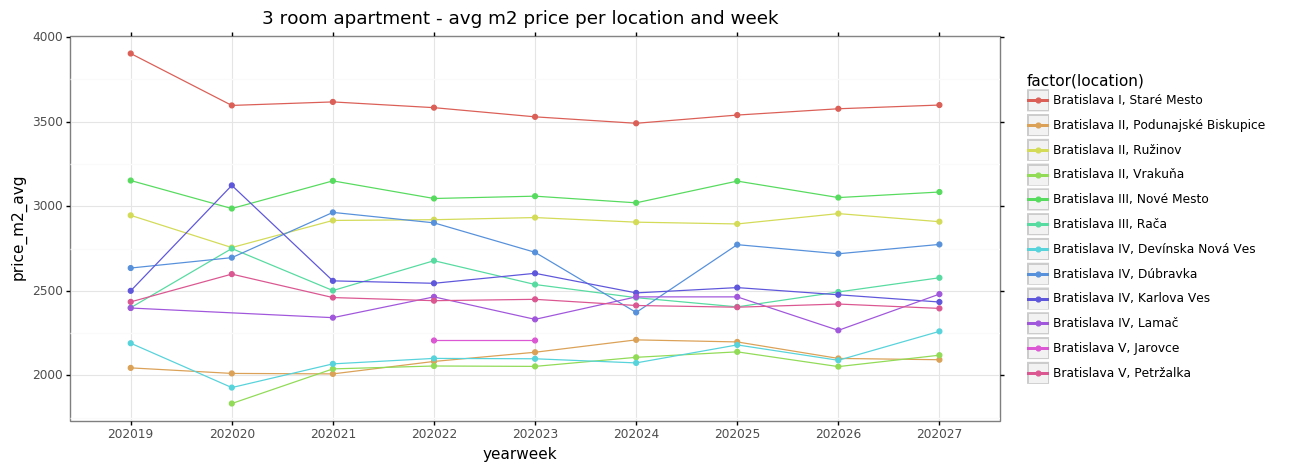

<ggplot: (-9223371874310416448)>


In [87]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df16.loc[df16['category'] == '3 izbový byt',:])
    + geom_line()
    + geom_point()
    + labs(title = '3 room apartment - avg m2 price per location and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

## avg m2 price per state

In [88]:
q18 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state', '_id.yearweek':'yearweek'})
df18 = df18[['state', 'yearweek', 'price_m2_avg']]
df19 = df18.pivot_table(columns = 'yearweek', index = 'state', values = 'price_m2_avg')

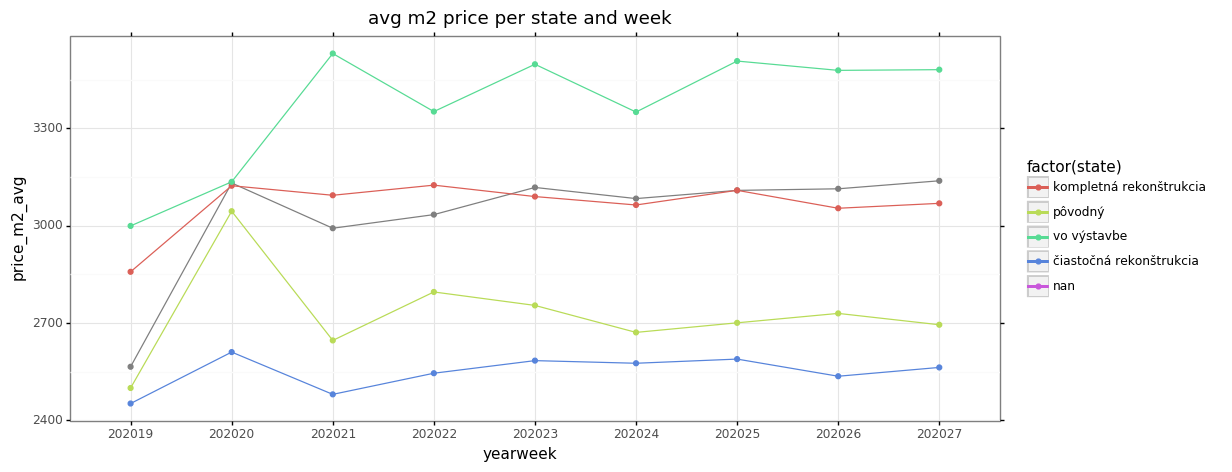

<ggplot: (-9223371874310357164)>


In [89]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df18)
    + geom_line()
    + geom_point()
    + labs(title = 'avg m2 price per state and week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

In [90]:
df19.style.format("{:.0f}")

In [91]:
q18 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df18 = pd.json_normalize(q18)\
    .rename(columns = {'_id.state':'state'})\
    .sort_values('price_m2_avg', ascending = False)
df18 = df18[['state', 'price_m2_avg', 'ads_count']]
df18.style.format({'price_m2_avg':"{:.0f}"})

## avg m2 price per state and category

In [92]:
q19 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category', '_id.yearweek': 'yearweek'})
df19 = df19[['state', 'category', 'yearweek', 'price_m2_avg']]
df20 = df19.pivot_table(index = ['category', 'state'], columns = 'yearweek', values = 'price_m2_avg')

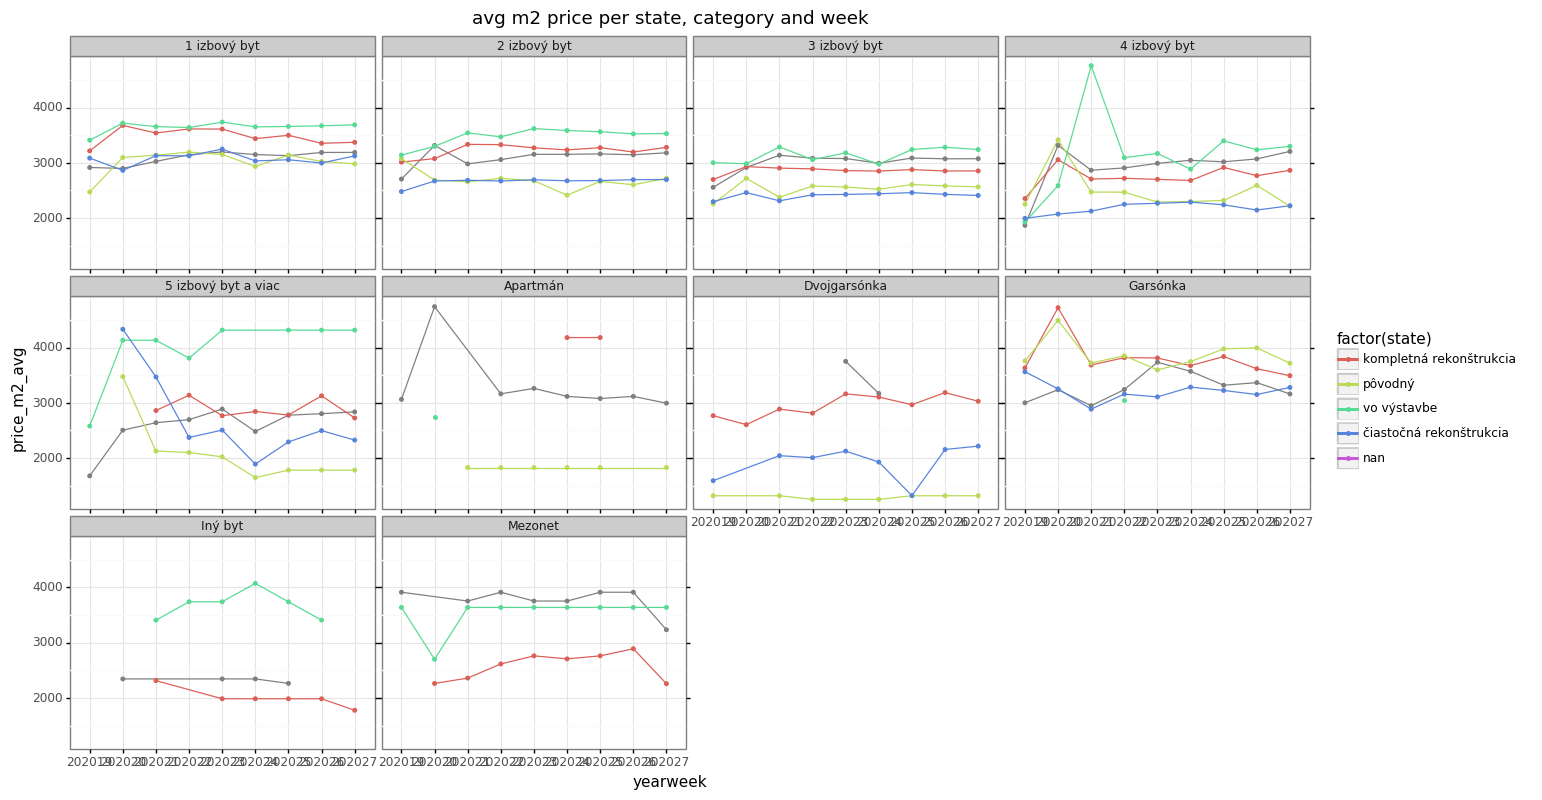

<ggplot: (-9223371874310043396)>


In [93]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(state)', group = 'factor(state)'), 
            data = df19)
    + facet_wrap('category')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per state, category and week')
    + theme_bw()
    + theme(figure_size = (16, 9)))

print(p)

In [94]:
df20.style.format("{:.0f}", na_rep = '-')

In [95]:
q19 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df19 = pd.json_normalize(q19)\
    .rename(columns = {'_id.state':'state', '_id.category':'category'})\
    .sort_values(['state', 'price_m2_avg'], ascending = False)
df19 = df19[['state', 'category', 'price_m2_avg', 'ads_count']]
df19 = df19.pivot(index = 'state', columns = 'category', values = 'price_m2_avg')
df19.style.format("{:.0f}", na_rep = '-')

## avg m2 price per state and location

In [96]:
q20 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek':'$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.yearweek':'yearweek'})
df20 = df20[['location', 'state', 'yearweek', 'price_m2_avg']]
df21 = df20.loc[df20['location'].isin(locs),:].pivot_table(index = ['state', 'location'], columns = 'yearweek', values = 'price_m2_avg')

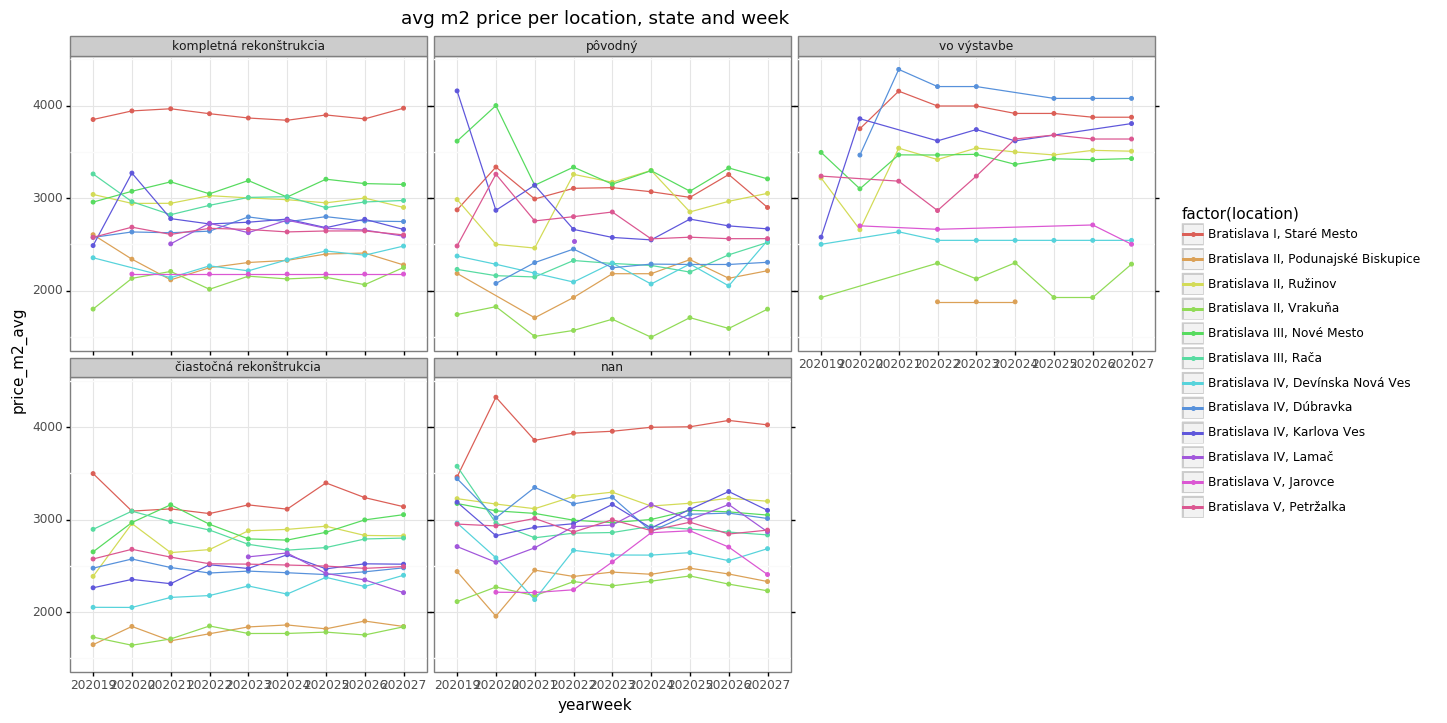

<ggplot: (-9223371874310331096)>


In [97]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df20.loc[df20['location'].isin(locs),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = 'avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [98]:
df21.style.format("{:.0f}", na_rep = '-')

In [99]:
q20 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df20 = pd.json_normalize(q20)\
    .rename(columns = {'_id.location':'location', '_id.state':'state'})\
    .sort_values('price_m2_avg', ascending = False)
df20 = df20[['location', 'state', 'price_m2_avg', 'ads_count']]
df20 = df20.loc[df20['location'].isin(locs),:].pivot(index = 'location', columns = 'state', values = 'price_m2_avg')
df20.style.format("{:.0f}", na_rep = '-')

## avg m2 price per state, location and category

In [100]:
q21 = list(adcollection.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties':1}
    },
	{'$group':{'_id':{'yearweek': '$yearweek', 'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'}}  
  }
	
]))
	
df21 = pd.json_normalize(q21)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category', '_id.yearweek':'yearweek'})
df22 = df21.loc[df21['location'].isin(locs),:].pivot_table(index = ['category', 'state', 'location'], columns = 'yearweek', values = 'price_m2_avg')
df22.style.format("{:.0f}", na_rep = '-')

In [101]:
q22 = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
	{'$group':{'_id':{'location':'$properties.Lokalita', 'state':'$properties.Stav', 'category':'$properties.Kategória'},
			'price_m2_avg':{'$avg':'$properties.Cena za meter'},
              'ads_count':{'$sum':1}}
		
  
  }
	
]))
	
df22 = pd.json_normalize(q22)\
    .rename(columns = {'_id.location':'location', '_id.state':'state', '_id.category':'category'})\
    .sort_values('price_m2_avg', ascending = False)
df22 = df22.loc[df22['location'].isin(locs),:].pivot_table(index = ['location', 'category'], columns = 'state', values = ['price_m2_avg', 'ads_count'])
df22.columns = df22.columns.swaplevel(0, 1)
df22.sort_index(axis=1, level=0, inplace=True)
df22.style.format("{:.0f}", na_rep = '-')

### 2 room apartment

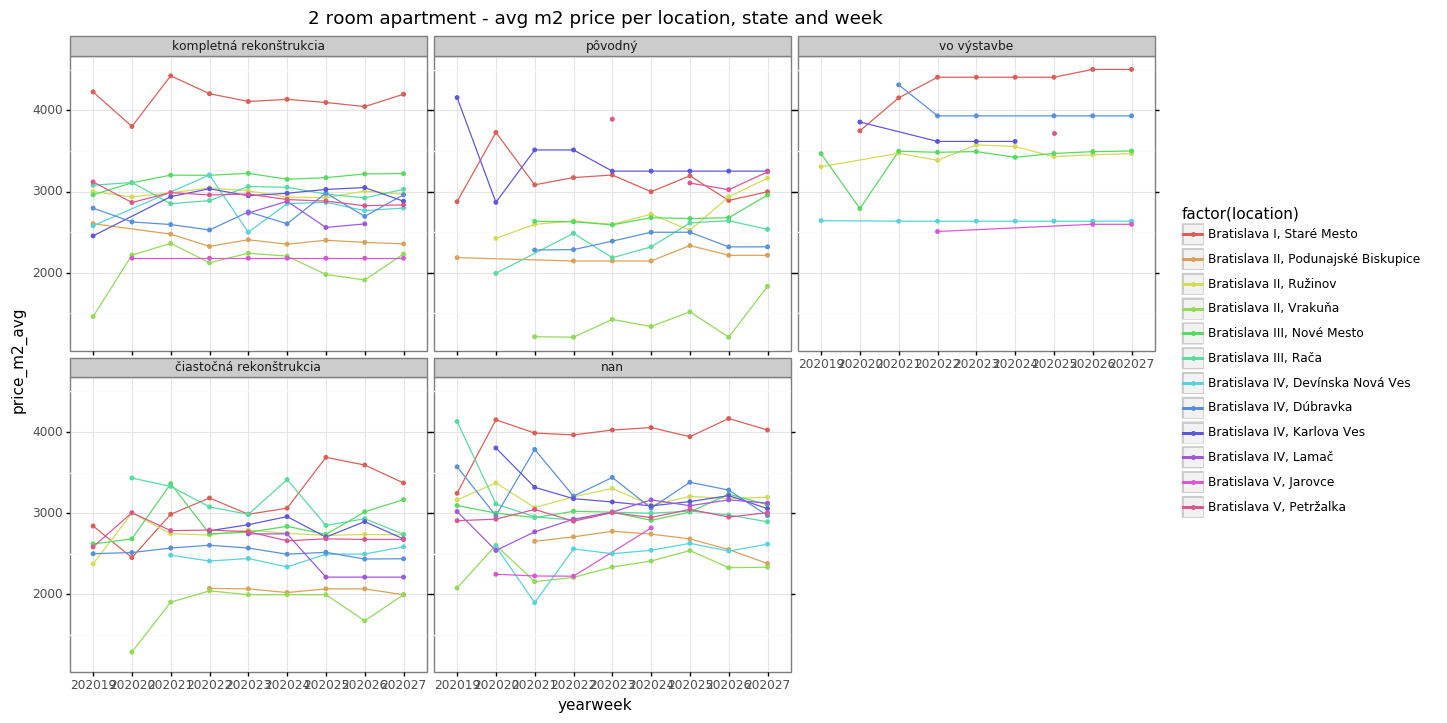

<ggplot: (-9223371874312009964)>


In [102]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '2 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment - avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

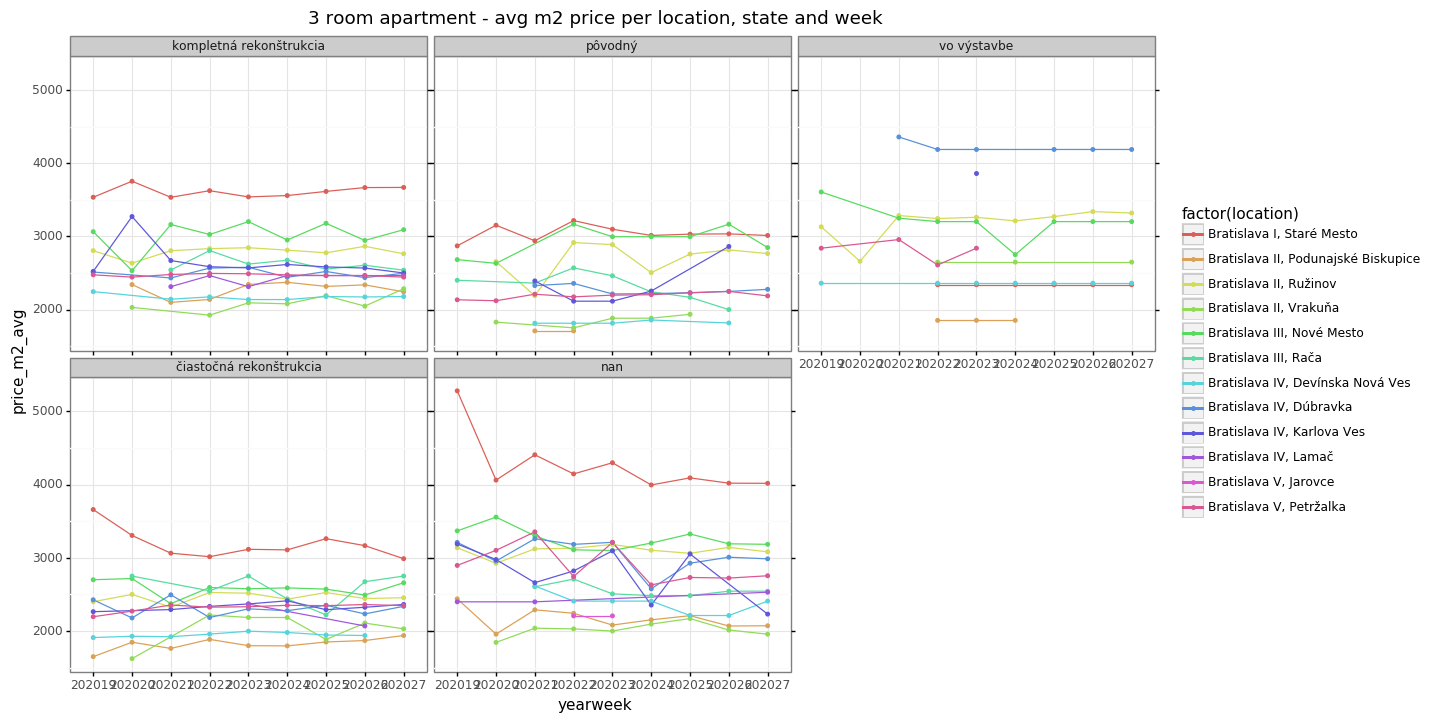

<ggplot: (-9223371874312241460)>


In [103]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2_avg', color = 'factor(location)', group = 'factor(location)'), 
            data = df21.loc[(df21['category']== '3 izbový byt') & (df21['location'].isin(locs)),:])
    + facet_wrap('state')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment - avg m2 price per location, state and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# DISTRIBUTION SELECTED CHARTS

# PRICE

In [147]:
q_all = list(adcollection_d.aggregate([
    {'$match':{'scraped timestamp': {'$lt': end, '$gte': start}}},
    {'$project':{'yearweek':{'$concat':[{'$toString':{'$year':'$scraped timestamp'}},
       {'$toString':{'$week':'$scraped timestamp'}}]
        },
        'properties.Cena':1, 'properties.Lokalita':1, 'properties.Stav':1, 'properties.Stav nehnuteľnosti:':1, 'properties.Kategória':1, 'properties.Cena za meter':1}
    }
	
]))
	
df_all = pd.json_normalize(q_all)\
    .rename(columns = {'properties.Cena':'price', 'properties.Lokalita':'location', 
                       'properties.Stav':'state', 'properties.Stav nehnuteľnosti:':'property_state', 
                       'properties.Kategória':'category', 'properties.Cena za meter':'price_m2'})
df_all.head()

_id yearweek     price                    location  \
0  5eca5e4b0c96711b2390988f   202021  124000.0  Bratislava IV, Karlova Ves   
1  5ed3c7c68441bf22ddf69dfc   202022  143000.0     Bratislava V, Petržalka   
2  5eef5b0ebaf17818a7facd3f   202025  273000.0   Bratislava I, Staré Mesto   
3  5ee65cc193e00353d3af8546   202024  147000.0        Bratislava III, Rača   
4  5eb86d9051a61f07621fbe5c   202019  181400.0      Bratislava II, Ružinov   

                     state      category  price_m2 property_state  
0  kompletná rekonštrukcia  1 izbový byt    3179.0            NaN  
1  čiastočná rekonštrukcia  2 izbový byt    2979.0            NaN  
2  kompletná rekonštrukcia  3 izbový byt    3900.0            NaN  
3  čiastočná rekonštrukcia  3 izbový byt    2673.0            NaN  
4  kompletná rekonštrukcia  4 izbový byt    2555.0            NaN

## overal histogram

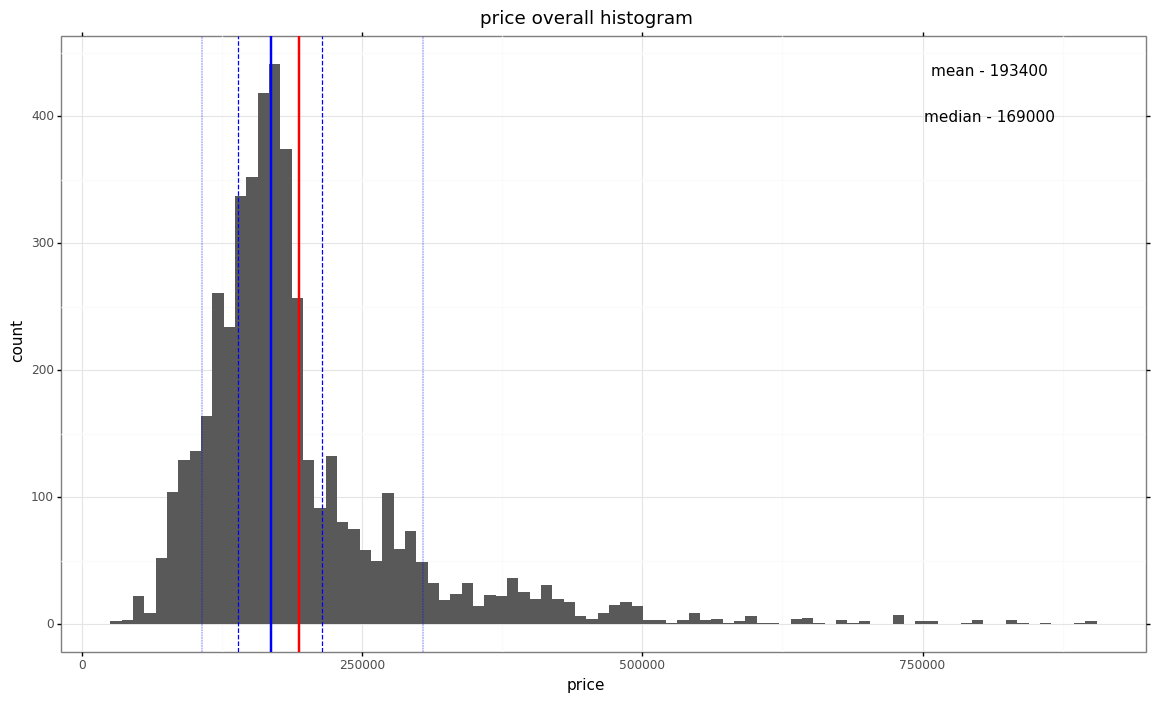

<ggplot: (-9223371874311974208)>


In [116]:
p = (ggplot(aes(x = 'price'), 
            data = df_all)
    + geom_histogram()
    + geom_vline(aes(xintercept = 'price.mean()'), color = 'red', size = 1)
    + geom_vline(aes(xintercept = 'price.median()'), color = 'blue', size = 1)
    + geom_vline(aes(xintercept = 'price.quantile(0.25)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price.quantile(0.75)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price.quantile(0.1)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + geom_vline(aes(xintercept = 'price.quantile(0.9)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + annotate('text', x=0.9*df_all['price'].max(), y = len(df_all)/11, label=f"mean - {int(df_all.price.mean())}")
    + annotate('text', x=0.9*df_all['price'].max(), y = len(df_all)/12, label=f"median - {int(df_all.price.median())}")
    + labs(title = 'price overall histogram')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [126]:
def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

df_all_yw =  df_all.groupby('yearweek', as_index = False)\
    .agg({'price':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = 'yearweek')
df_all_yw.columns = ['yearweek', 'metric', 'price']
df_all_yw.head()

yearweek metric     price
0   202019    q10   91940.0
1   202020    q10  103794.0
2   202021    q10   96800.0
3   202022    q10  104972.0
4   202023    q10  114900.0

## overall - ts

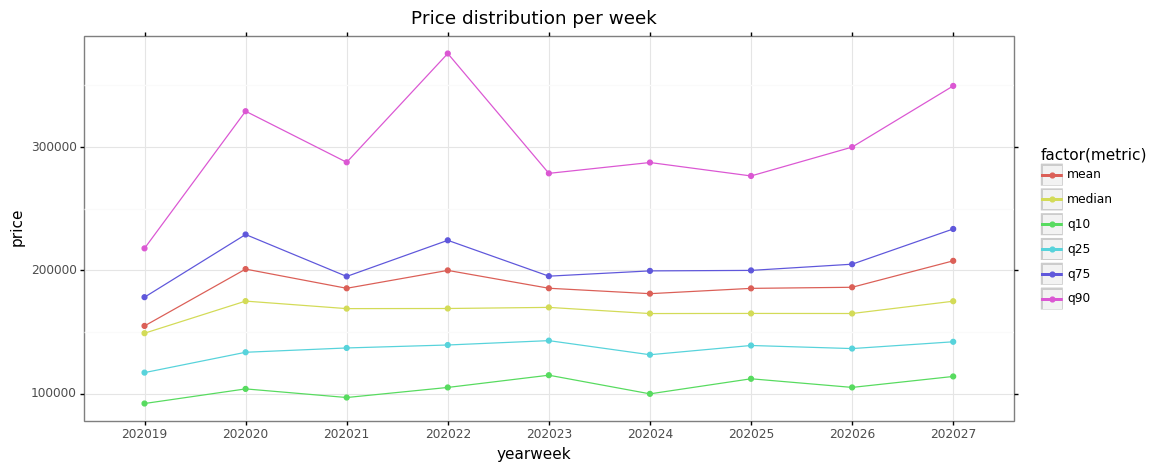

<ggplot: (-9223371874312185836)>


In [128]:
p = (ggplot(aes(x = 'yearweek', y = 'price', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw)
    + geom_line()
    + geom_point()
    + labs(title = 'Price distribution per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

##  per state, location and category

### 2 room apartment

In [139]:
df_all_yw =  df_all.groupby(['yearweek', 'location', 'state', 'category'], as_index = False)\
    .agg({'price':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'location', 'state', 'category','q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = ['yearweek', 'location', 'state', 'category'])
df_all_yw.columns = ['yearweek', 'location', 'state', 'category', 'metric', 'price']
df_all_yw.head()

yearweek                   location                    state      category  \
0   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  1 izbový byt   
1   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  2 izbový byt   
2   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  3 izbový byt   
3   202019  Bratislava I, Staré Mesto                  pôvodný  3 izbový byt   
4   202019  Bratislava I, Staré Mesto  čiastočná rekonštrukcia  2 izbový byt   

  metric     price  
0    q10  179300.0  
1    q10  191145.0  
2    q10  285899.1  
3    q10  310000.0  
4    q10  196000.0

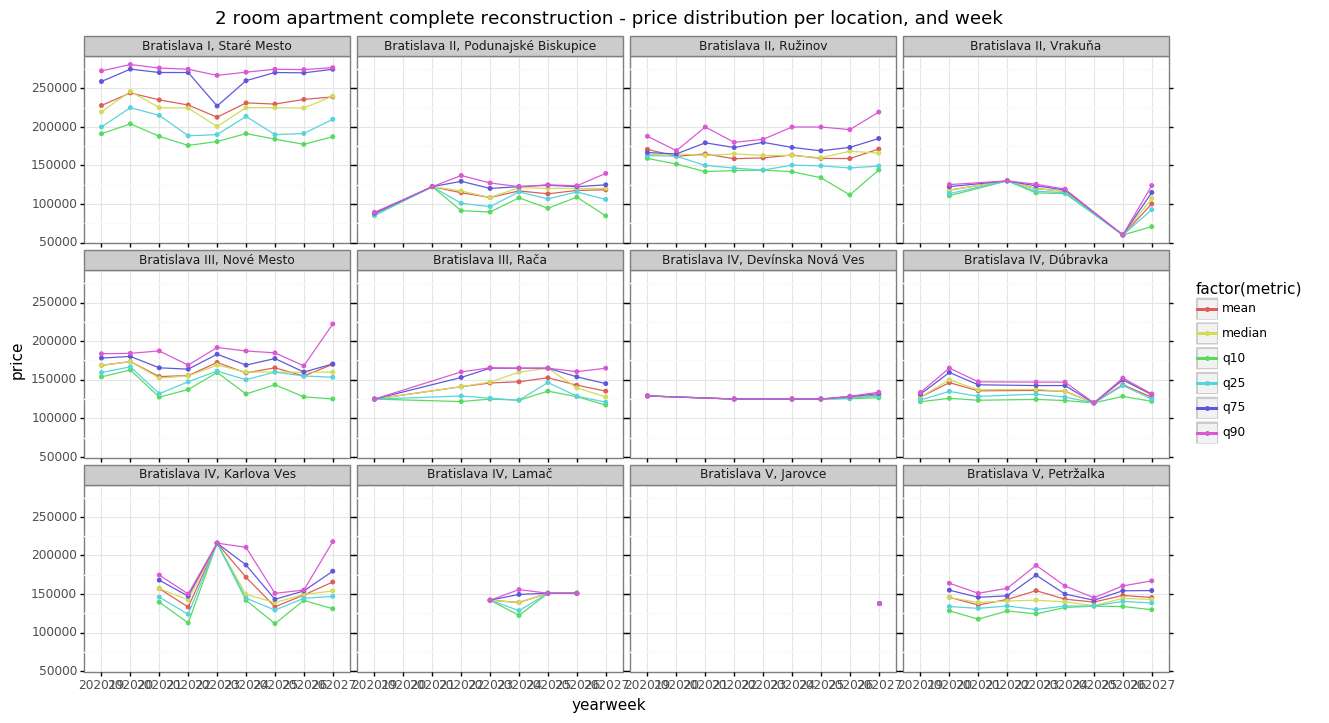

<ggplot: (-9223371874310024544)>


In [142]:
p = (ggplot(aes(x = 'yearweek', y = 'price', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '2 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment complete reconstruction - price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

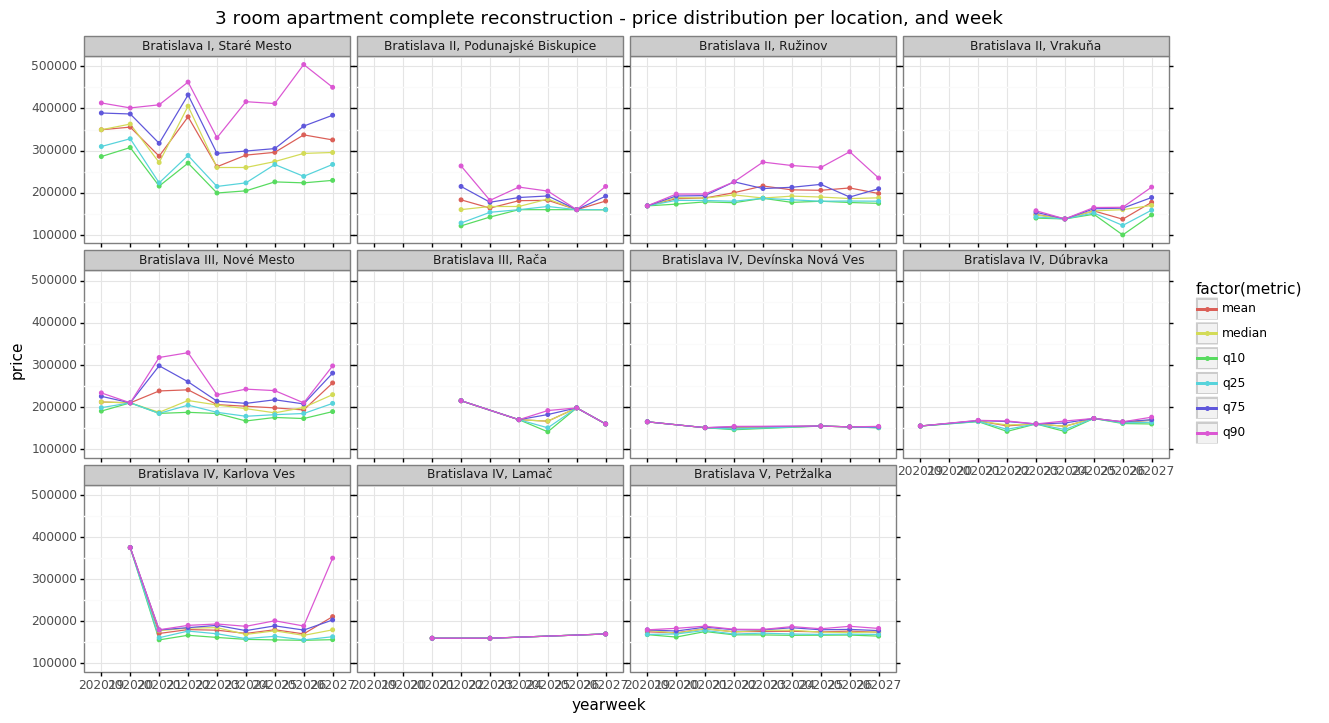

<ggplot: (-9223371874311950192)>


In [148]:
p = (ggplot(aes(x = 'yearweek', y = 'price', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '3 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment complete reconstruction - price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# M2 PRICE

## overal histogram

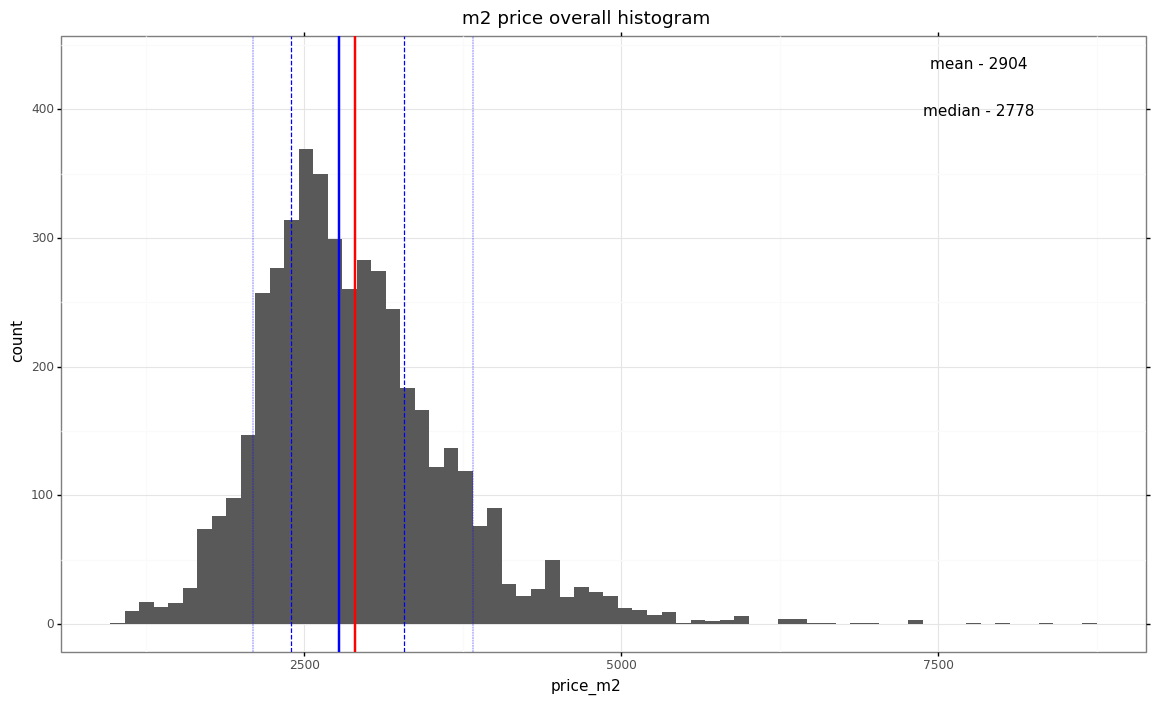

<ggplot: (-9223371874309831100)>


In [150]:
p = (ggplot(aes(x = 'price_m2'), 
            data = df_all)
    + geom_histogram()
    + geom_vline(aes(xintercept = 'price_m2.mean()'), color = 'red', size = 1)
    + geom_vline(aes(xintercept = 'price_m2.median()'), color = 'blue', size = 1)
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.25)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.75)'), color = 'blue', linetype = 'dashed')
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.1)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + geom_vline(aes(xintercept = 'price_m2.quantile(0.9)'), color = 'blue', linetype = 'dashed', size = 0.2)
    + annotate('text', x=0.9*df_all['price_m2'].max(), y = len(df_all)/11, label=f"mean - {int(df_all.price_m2.mean())}")
    + annotate('text', x=0.9*df_all['price_m2'].max(), y = len(df_all)/12, label=f"median - {int(df_all.price_m2.median())}")
    + labs(title = 'm2 price overall histogram')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

In [151]:
def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

df_all_yw =  df_all.groupby('yearweek', as_index = False)\
    .agg({'price_m2':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = 'yearweek')
df_all_yw.columns = ['yearweek', 'metric', 'price_m2']
df_all_yw.head()

yearweek metric  price_m2
0   202019    q10    1583.0
1   202020    q10    2258.8
2   202021    q10    2123.8
3   202022    q10    2041.6
4   202023    q10    2171.2

## overall - ts

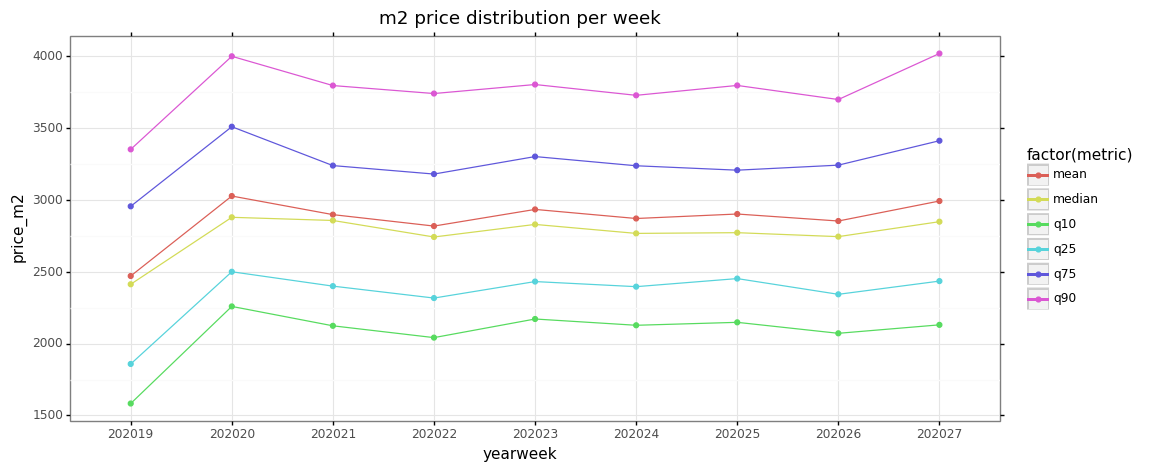

<ggplot: (-9223371874312166508)>


In [152]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw)
    + geom_line()
    + geom_point()
    + labs(title = 'm2 price distribution per week')
    + theme_bw()
    + theme(figure_size = (12, 5)))

print(p)

##  per state, location and category

### 2 room apartment

In [153]:
df_all_yw =  df_all.groupby(['yearweek', 'location', 'state', 'category'], as_index = False)\
    .agg({'price_m2':[q10, q25, 'median', 'mean', q75, q90]})
df_all_yw.columns = ['yearweek', 'location', 'state', 'category','q10', 'q25', 'median', 'mean', 'q75', 'q90']
df_all_yw = df_all_yw.melt(id_vars = ['yearweek', 'location', 'state', 'category'])
df_all_yw.columns = ['yearweek', 'location', 'state', 'category', 'metric', 'price_m2']
df_all_yw.head()

yearweek                   location                    state      category  \
0   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  1 izbový byt   
1   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  2 izbový byt   
2   202019  Bratislava I, Staré Mesto  kompletná rekonštrukcia  3 izbový byt   
3   202019  Bratislava I, Staré Mesto                  pôvodný  3 izbový byt   
4   202019  Bratislava I, Staré Mesto  čiastočná rekonštrukcia  2 izbový byt   

  metric  price_m2  
0    q10    4718.0  
1    q10    3353.5  
2    q10    3355.7  
3    q10    2870.0  
4    q10    2841.0

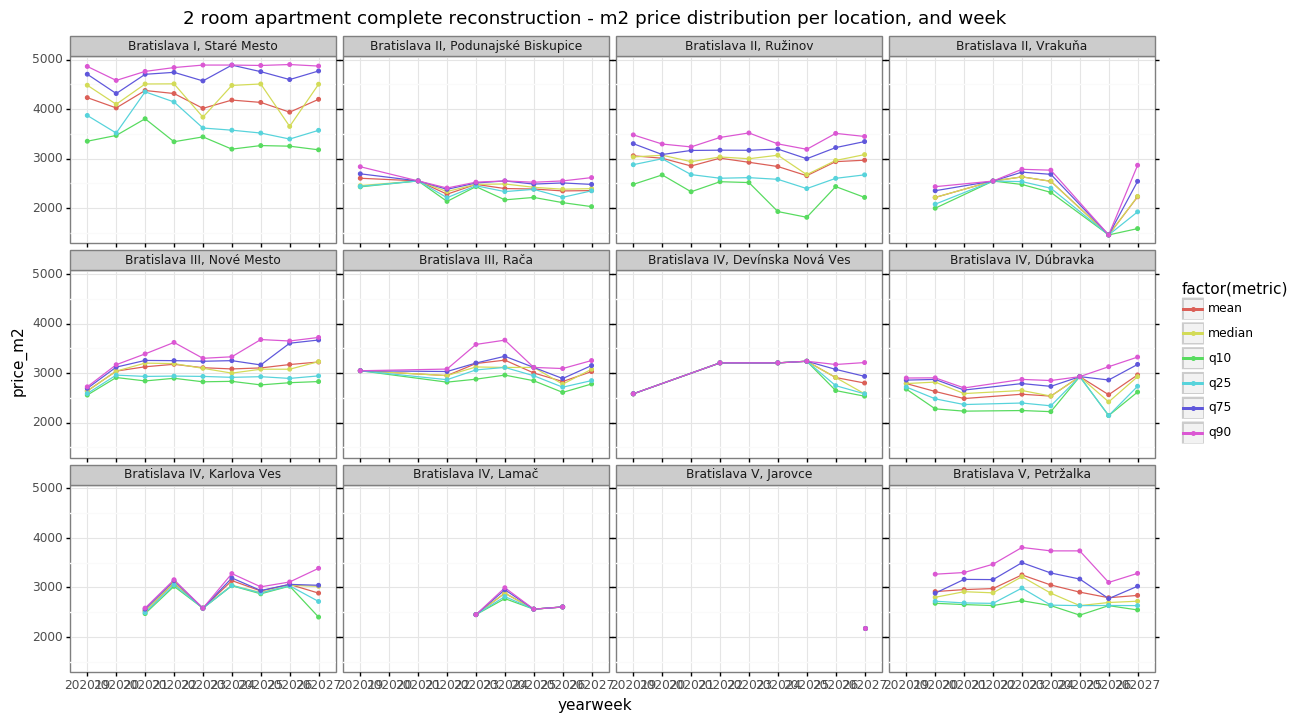

<ggplot: (-9223371874309334028)>


In [154]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '2 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '2 room apartment complete reconstruction - m2 price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

### 3 room apartment

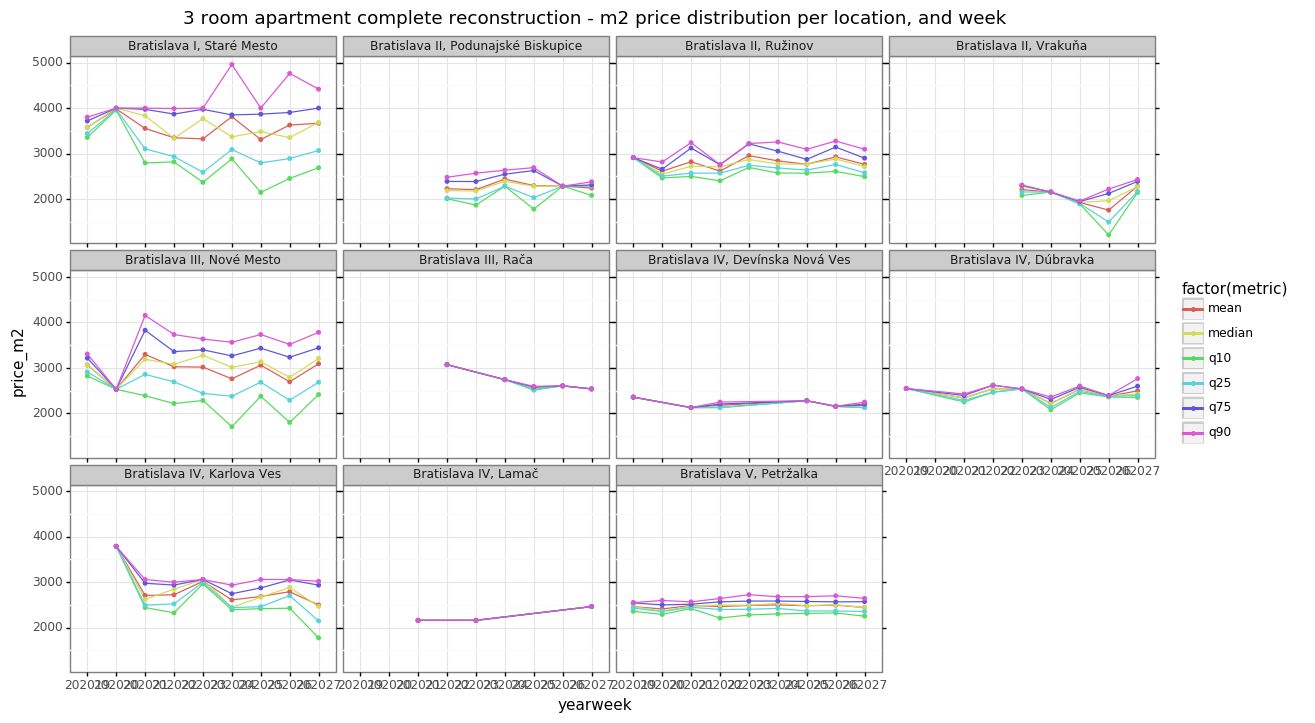

<ggplot: (-9223371874307374256)>


In [155]:
p = (ggplot(aes(x = 'yearweek', y = 'price_m2', color = 'factor(metric)', group = 'factor(metric)'), 
            data = df_all_yw.loc[(df_all_yw['category']== '3 izbový byt') & (df_all_yw['location'].isin(locs)) & (df_all_yw['state'] == 'kompletná rekonštrukcia'),:])
    + facet_wrap('location')
    + geom_line()
    + geom_point(size = 1)
    + labs(title = '3 room apartment complete reconstruction - m2 price distribution per location, and week')
    + theme_bw()
    + theme(figure_size = (14, 8)))

print(p)

# TODO

- another section DISTRIBUTION with charts, percentiles overall and as timeseries
- check properties.Stav vs properties.Stav nehnuteľnosti
- add to distribution section povodny stav charts 2 and 3 room apartments